# Main: ベイズ線形回帰

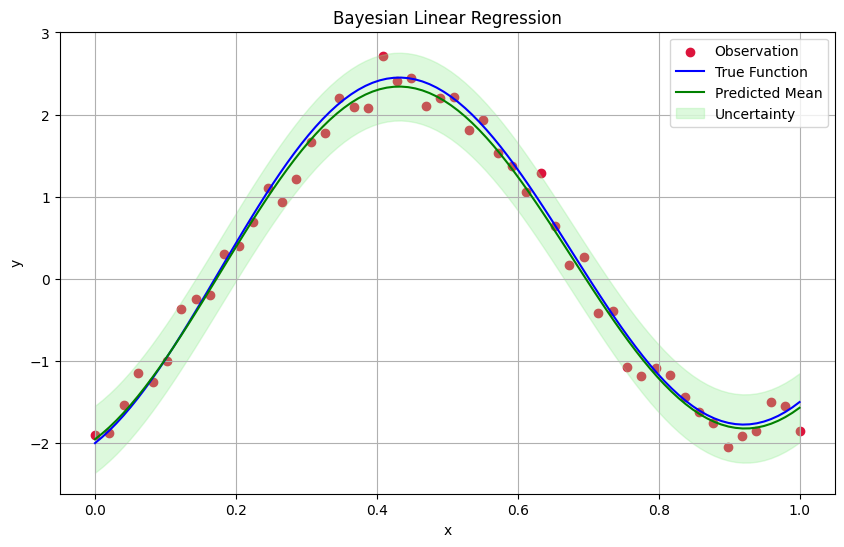

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from models import BayesianLinearRegression
from utils import plot_figure


# サンプルデータの生成
np.random.seed(42)
x = np.linspace(0, 1, 50)

#入力xに対してx , sin(2πx), cos(2πx) からなる特徴量行列Φを生成する関数
def calc_phi_tf(x):
    phi = np.column_stack([x, np.sin(2 * np.pi * x), np.cos(2 * np.pi * x)])  # 例として、3つの特徴量を使用
    return phi
phi = calc_phi_tf(x)

true_params = np.array([0.5, 1.0, -2.0]) #推定したいパラメータの真値
y_true = phi @ true_params # つまり, y = 0.5*x + 1*sin(2πx) + (-2)*cos(2πx) となっている。
sigma = 0.2 # ノイズの標準偏差(既知とした)
noise = np.random.randn(len(x)) * sigma  # ノイズの生成(平均0, 標準偏差sigmaの正規分布)
y = y_true + noise

# パラメータの事前分布の設定
alpha = 1
mu_prior = np.zeros(phi.shape[1])     # パラメータの事前平均をゼロベクトルで初期化
cov_prior = alpha * np.identity(phi.shape[1]) # パラメータの事前共分散行列を単位行列で初期化
beta = 1.0 / (sigma ** 2)             # ノイズの精度パラメータを計算(sigmaを既知としている)

# ベイズ線形回帰モデルの初期化
model = BayesianLinearRegression(mu_prior, cov_prior, alpha, beta)
# モデルの学習
model.update(phi, y)

# 新しい入力データに対する予測分布の計算(可視化用)
x_pred = np.linspace(0, 1, 100)
phi_pred = calc_phi_tf(x_pred)  # 予測に使用する特徴量行列
pred_mean, pred_cov = model.predict(phi_pred)
pred_std = np.sqrt(pred_cov)

# 可視化
plot_figure(x, y, x_pred, phi_pred, true_params, pred_mean, pred_std)

# Branch1: βが未知の場合のエビデンス関数の最大化(3.5.2)

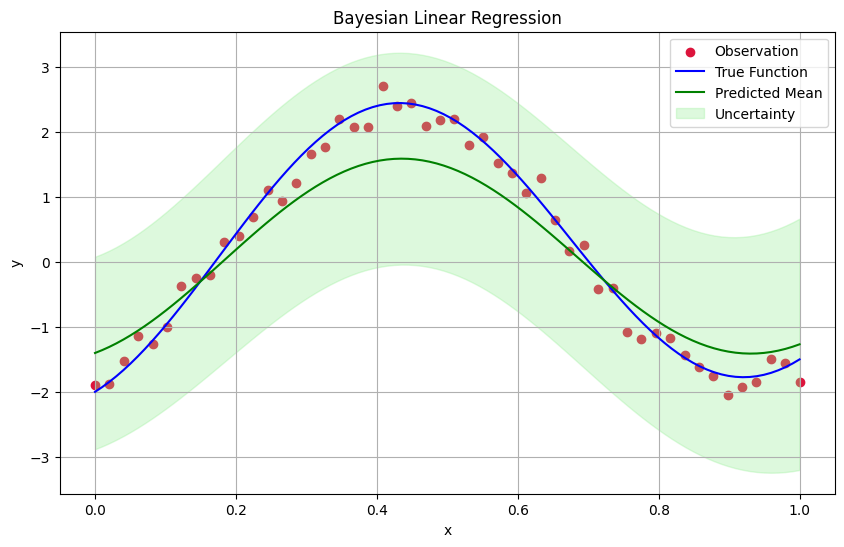

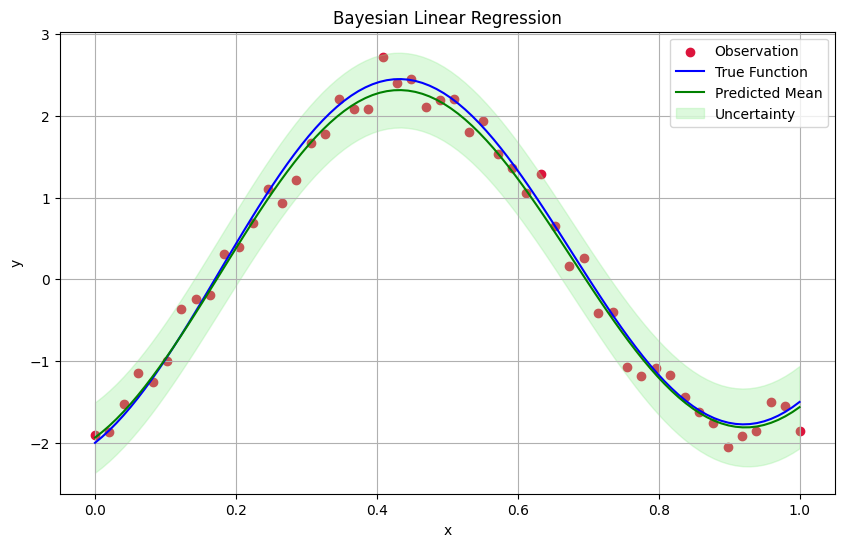

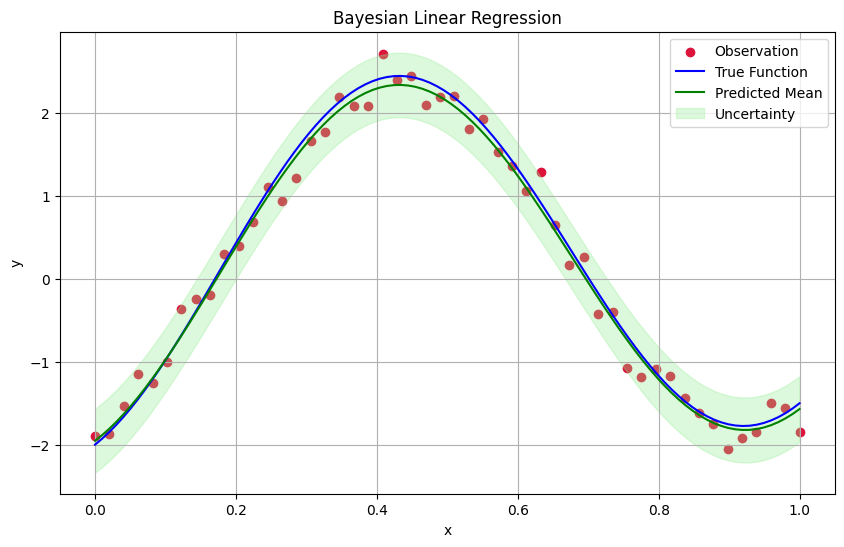

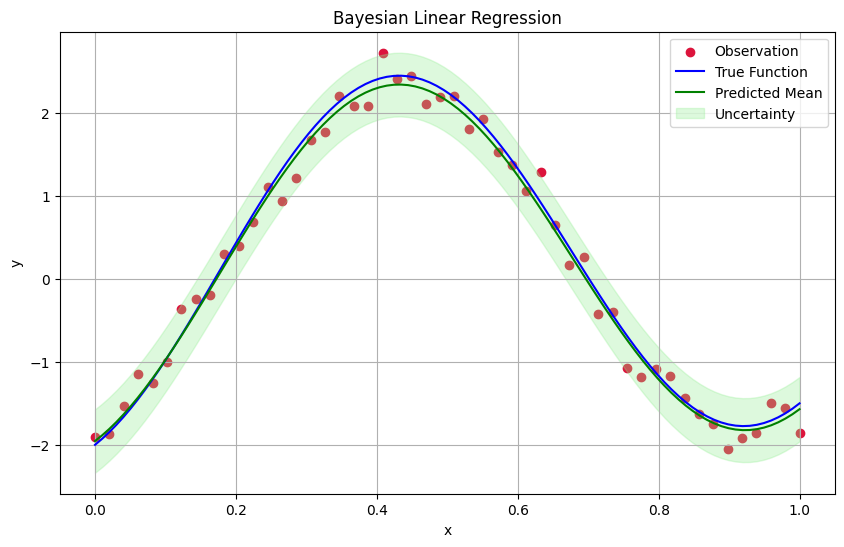

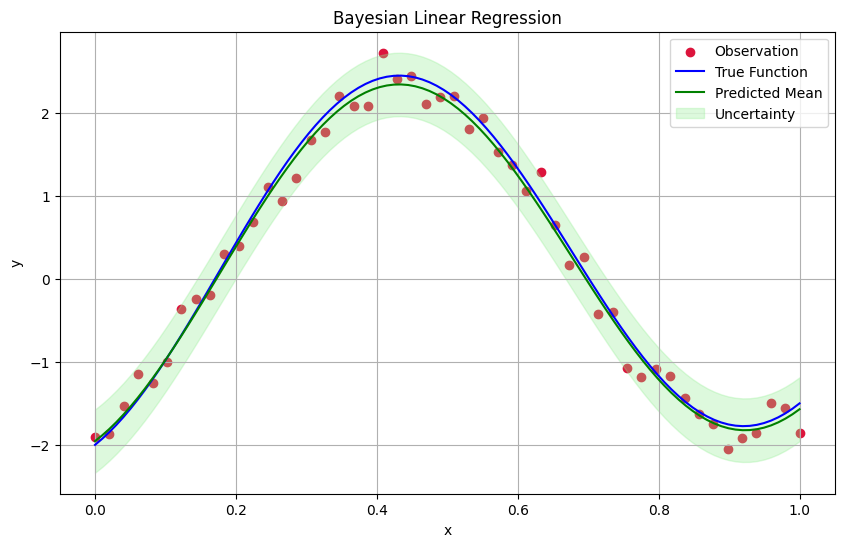

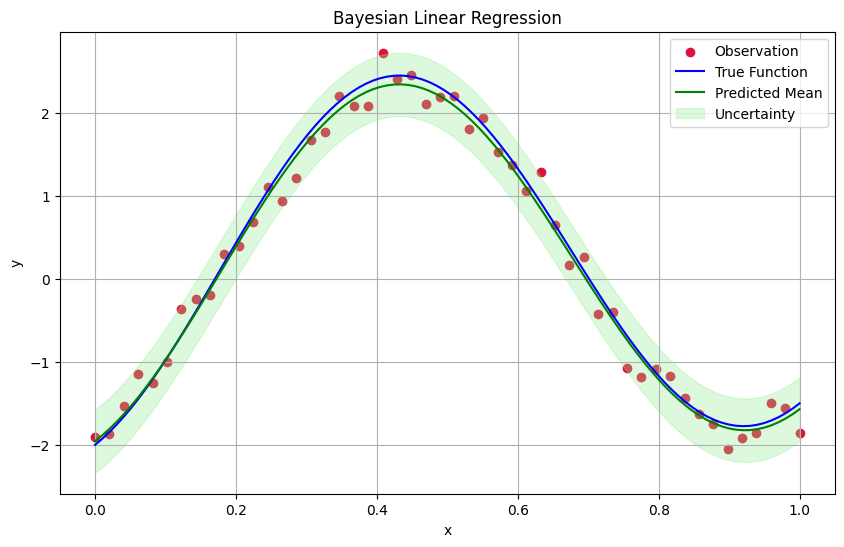

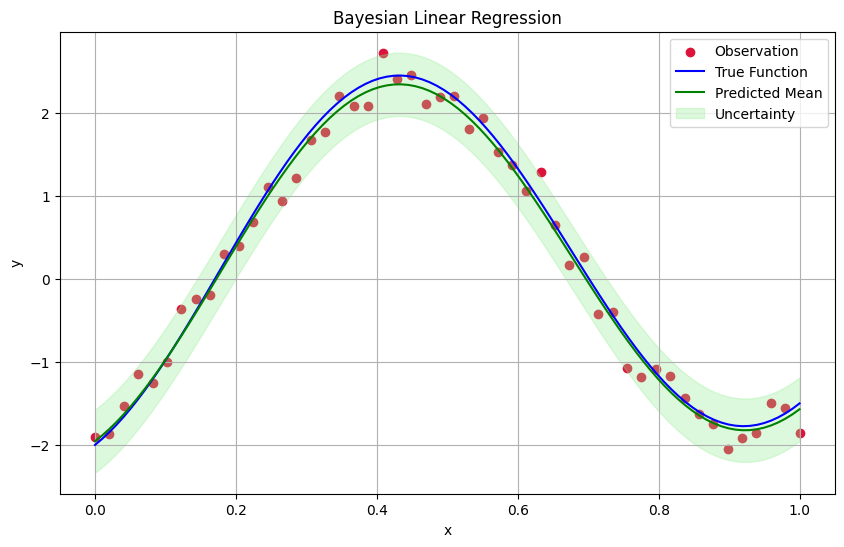

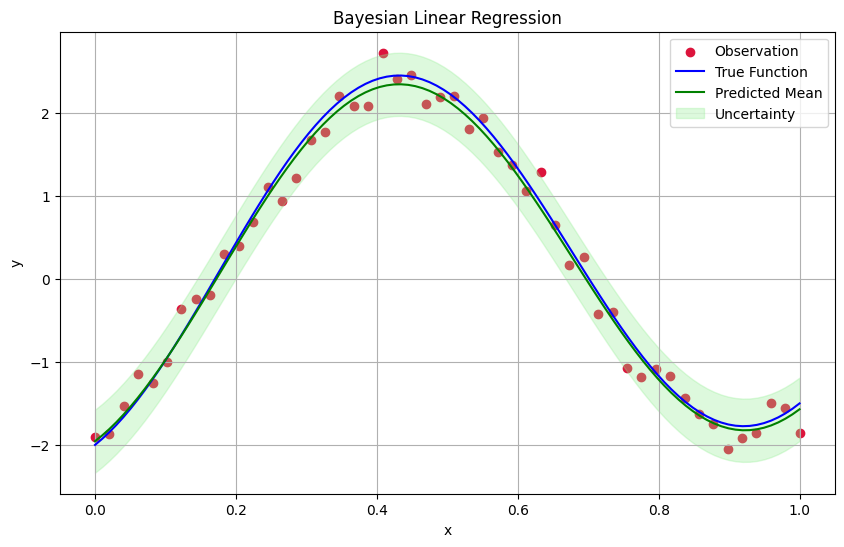

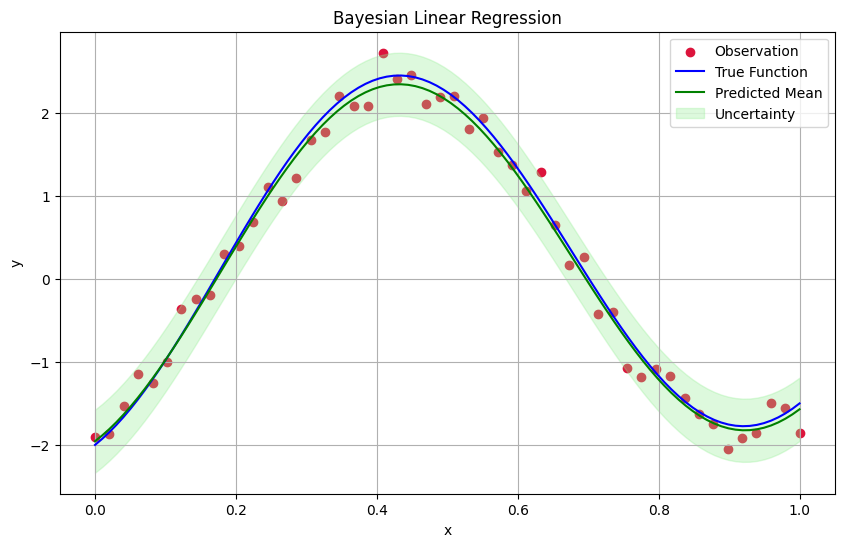

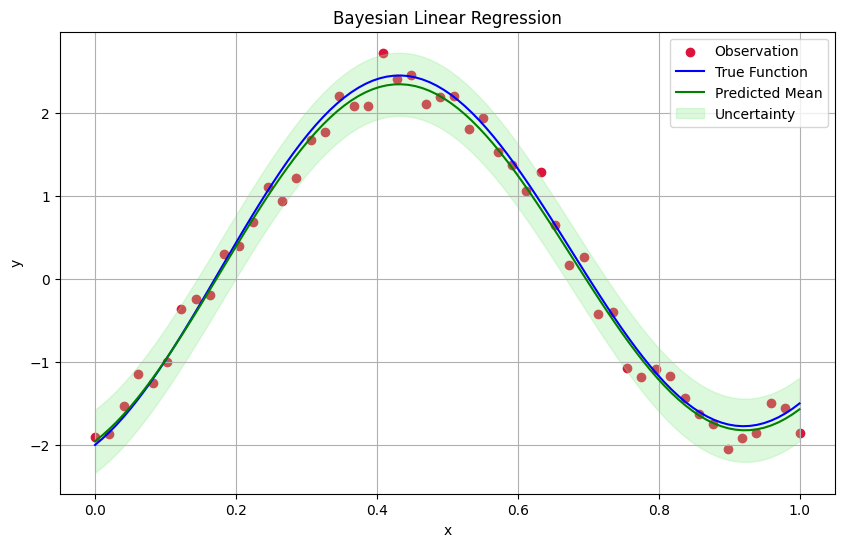

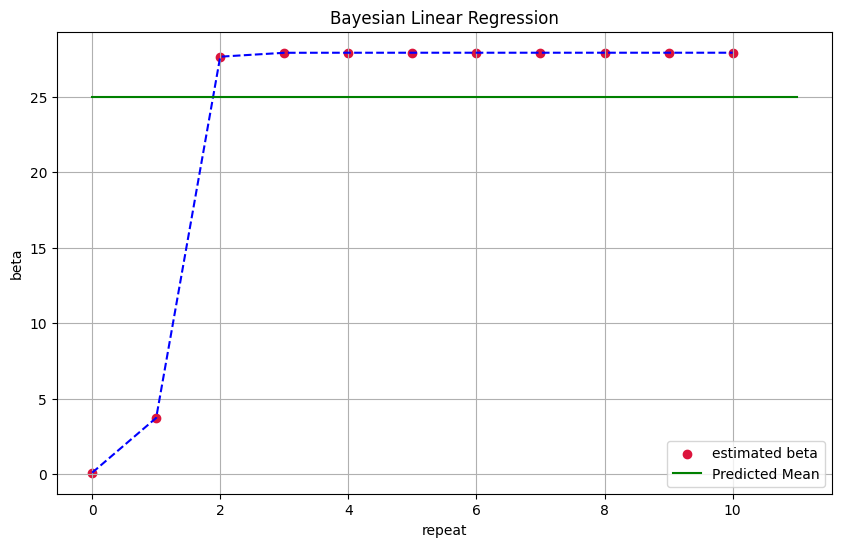

In [9]:
# パラメータの事前分布の設定
alpha = 1
mu_prior = np.zeros(phi.shape[1])     # パラメータの事前平均をゼロベクトルで初期化
cov_prior = alpha * np.identity(phi.shape[1]) # パラメータの事前共分散行列を単位行列で初期化

# βは未知として適当に置く!! これが最終的にbeta_trueに近づくことが目標
beta_prior = 0.1     
beta_true = 1.0 / (sigma ** 2)

# ベイズ線形回帰モデルの初期化
model = BayesianLinearRegression(mu_prior, cov_prior, alpha, beta_prior)

# 反復推定における各時点でのbetaをリストに記録しておく
beta_list = [beta_prior]

for i in range(10):
    # モデルの学習
    model.update(phi, y)
    # 事前確率mu, suの更新
    model.update_prior()
    # βの更新
    model.update_beta(phi, y)
    
    beta_list.append(model.beta) 
    
    # 新しい入力データに対する予測分布の計算
    x_pred = np.linspace(0, 1, 100)
    phi_pred = calc_phi_tf(x_pred)  # 予測に使用する特徴量行列
    pred_mean, pred_cov = model.predict(phi_pred)
    pred_std = np.sqrt(pred_cov)
    
    # 可視化
    plot_figure(x, y, x_pred, phi_pred, true_params, pred_mean, pred_std)

# betaの推移の可視化
plt.figure(figsize=(10, 6))
repeat = np.arange(0, len(beta_list), 1)
plt.scatter(repeat, beta_list, c='crimson', marker='o', label='estimated beta')
plt.plot(repeat, beta_list, color='blue', linestyle='--')
x_axis = np.linspace(0, len(beta_list),100)
plt.plot(x_axis, beta_true * np.ones_like(x_axis), label='Predicted Mean', color='green')
plt.title('Bayesian Linear Regression')
plt.xlabel('repeat')
plt.ylabel('beta')
plt.legend()
plt.grid(True)
plt.show()


# Branch2: モデルの逐次更新

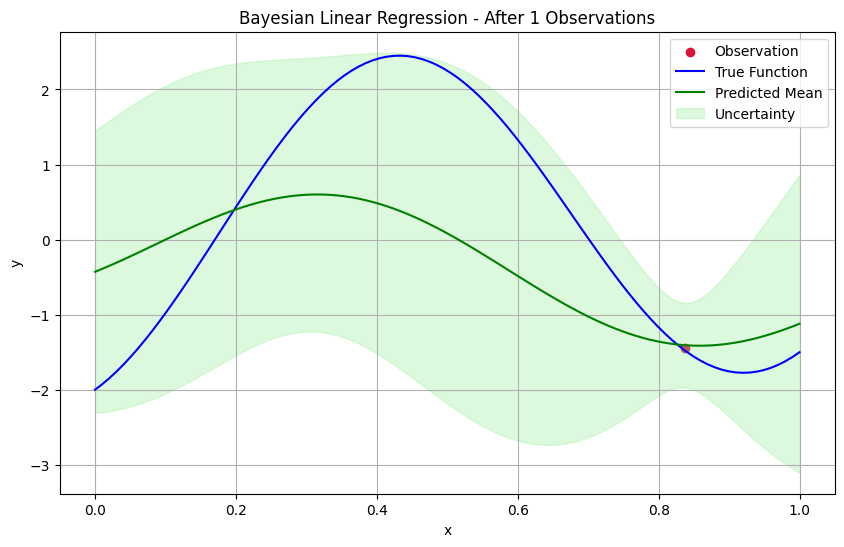

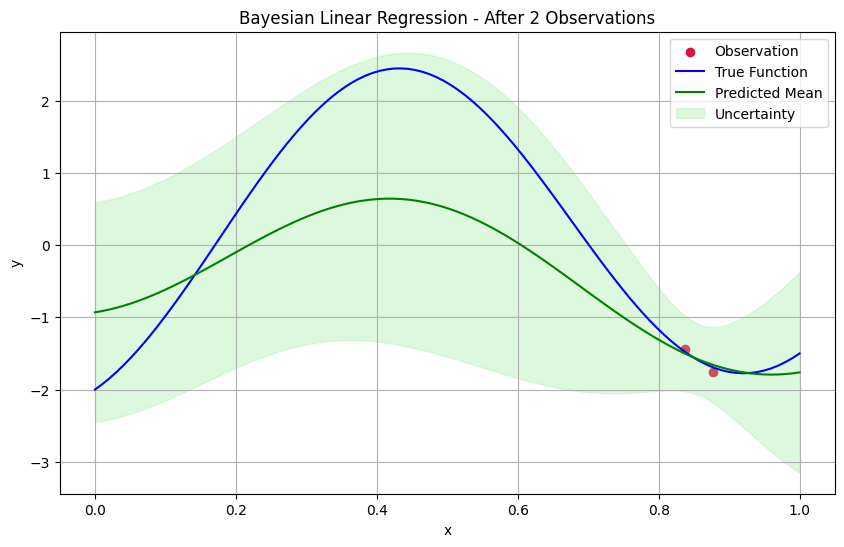

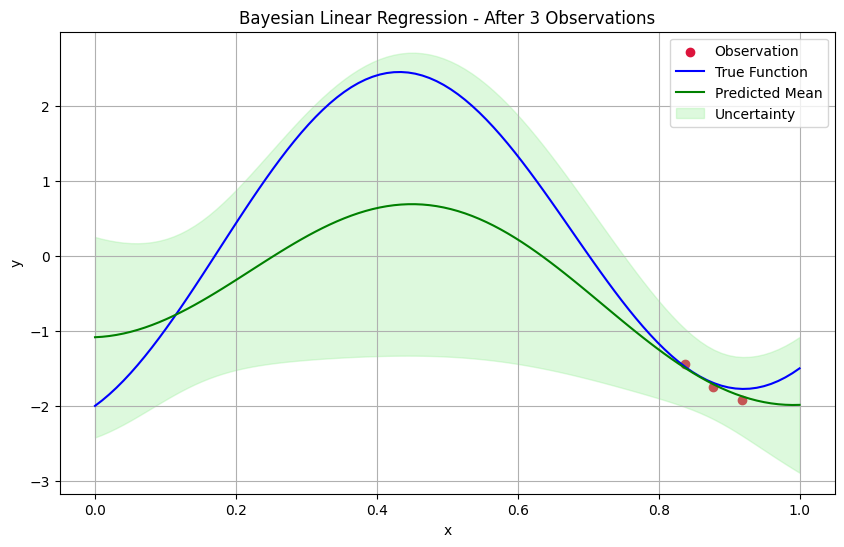

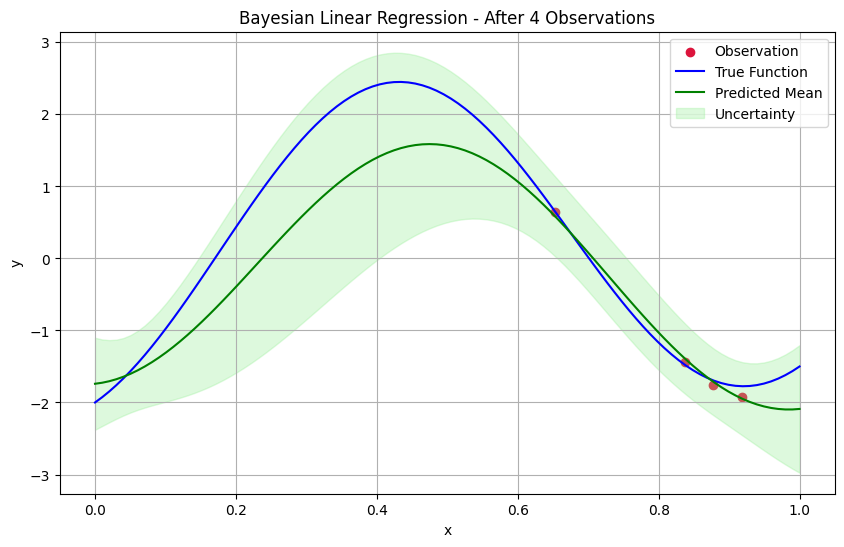

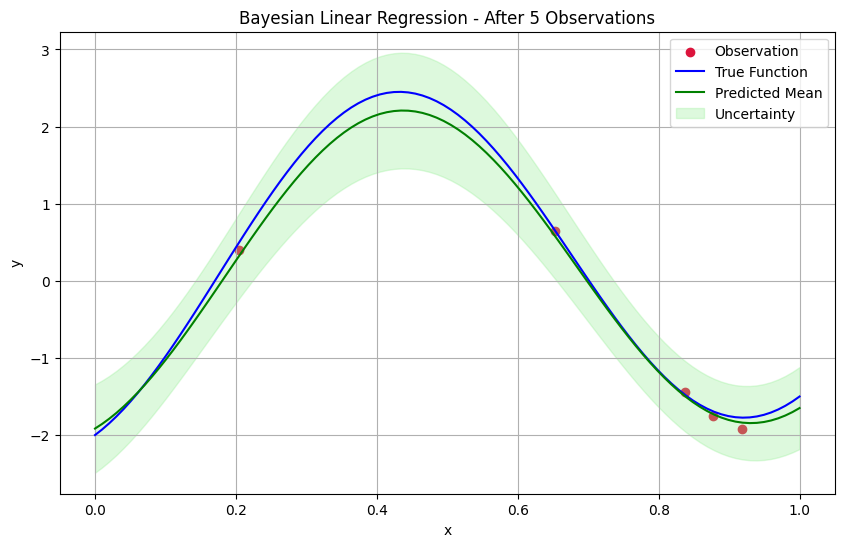

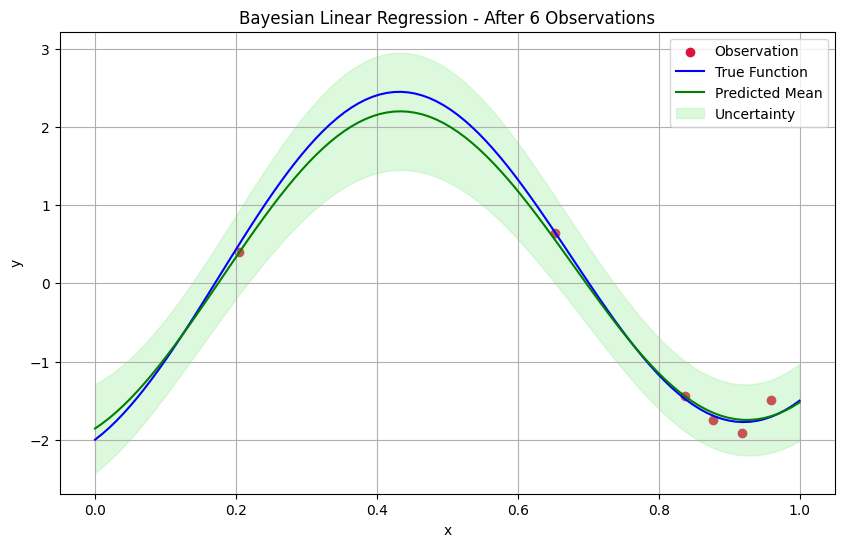

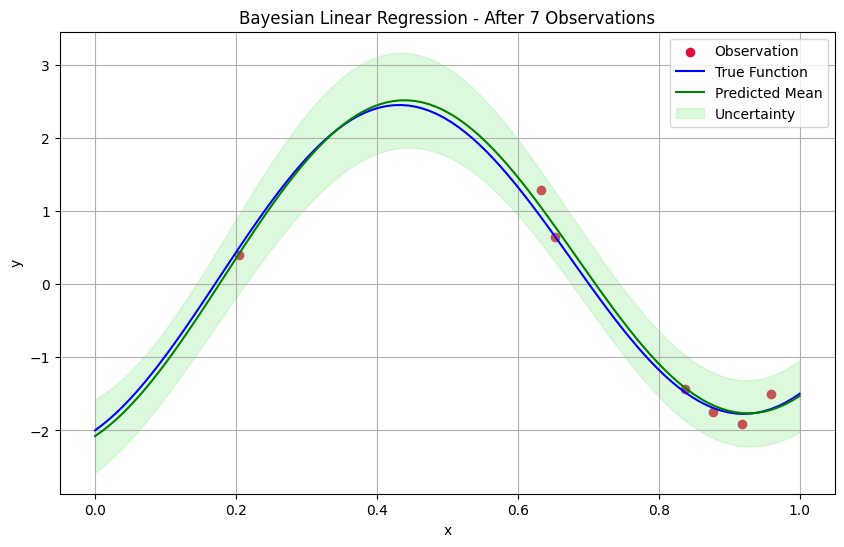

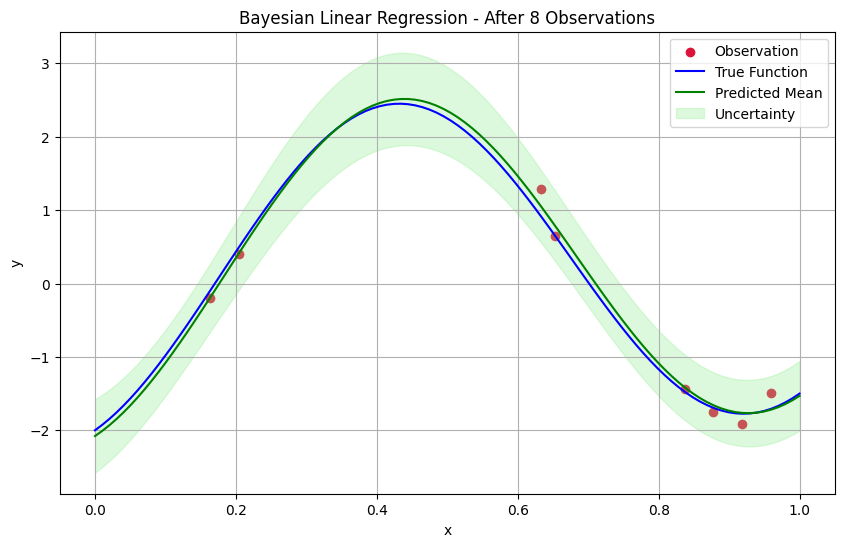

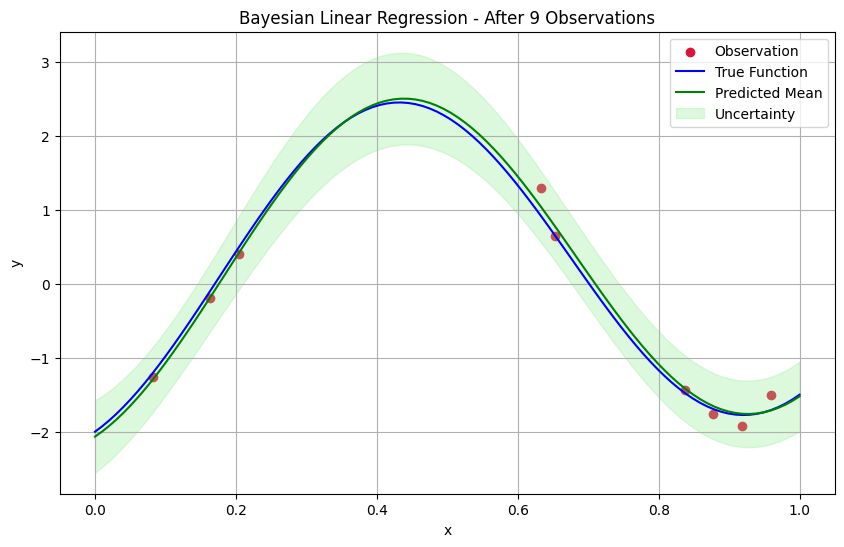

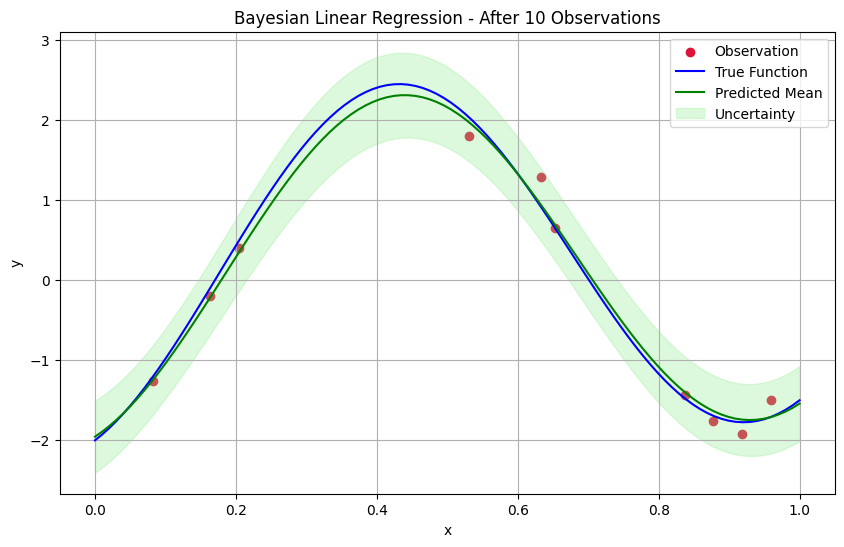

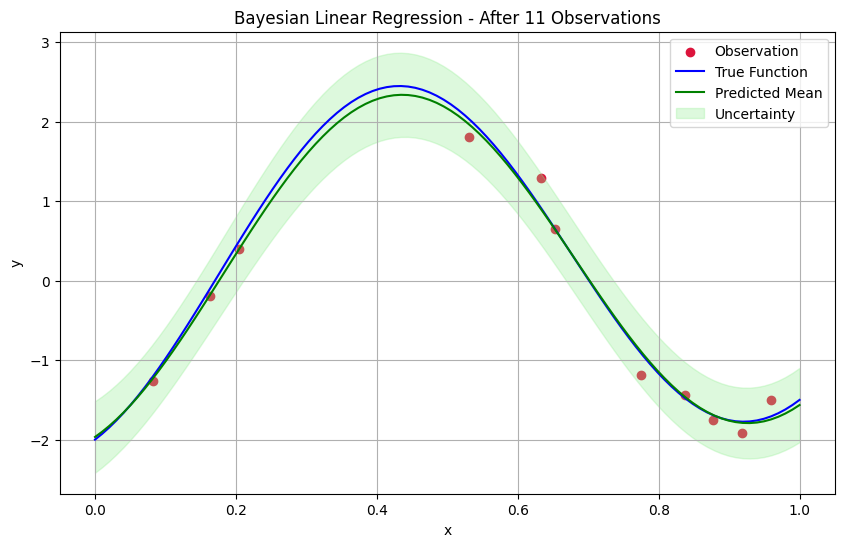

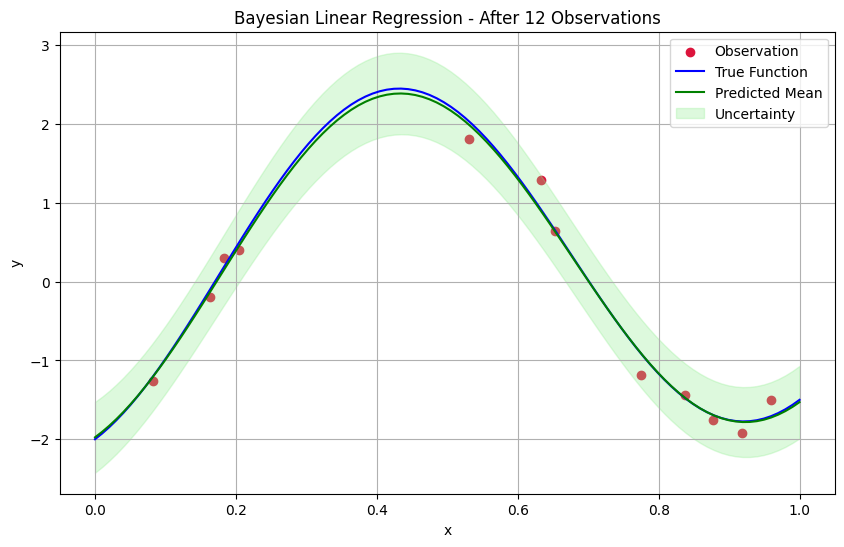

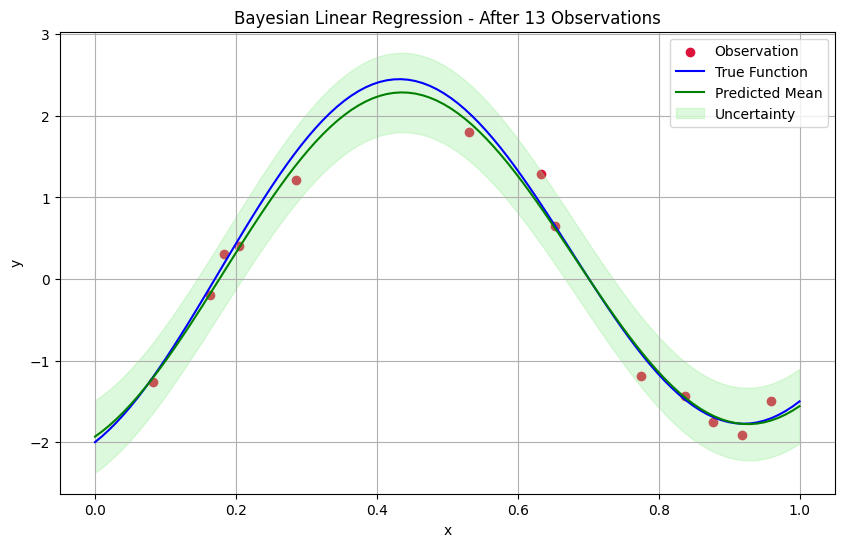

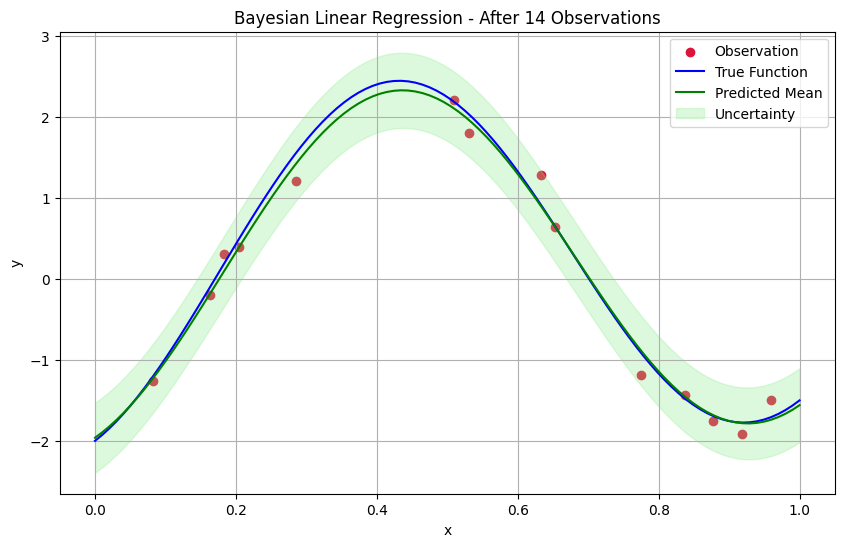

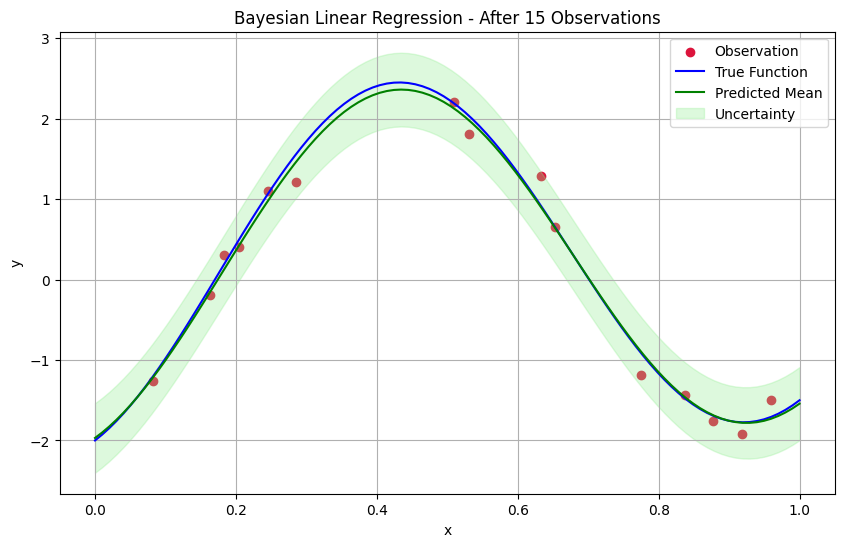

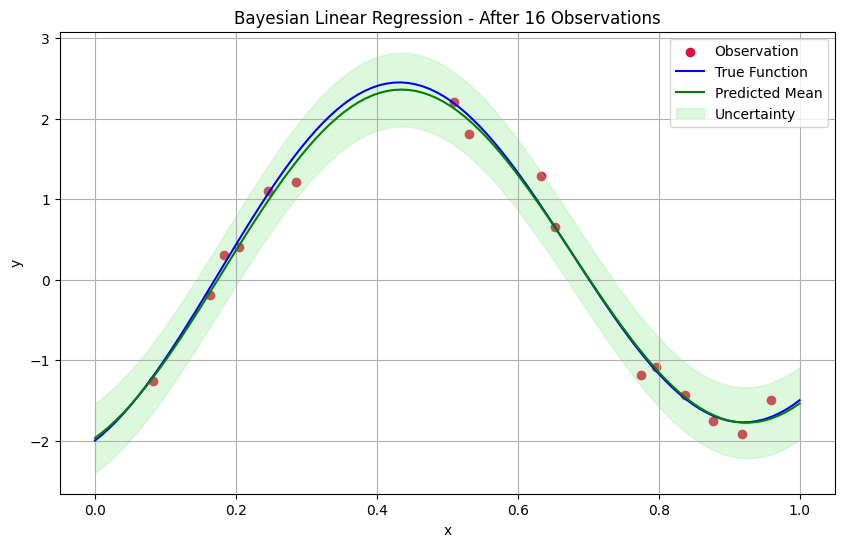

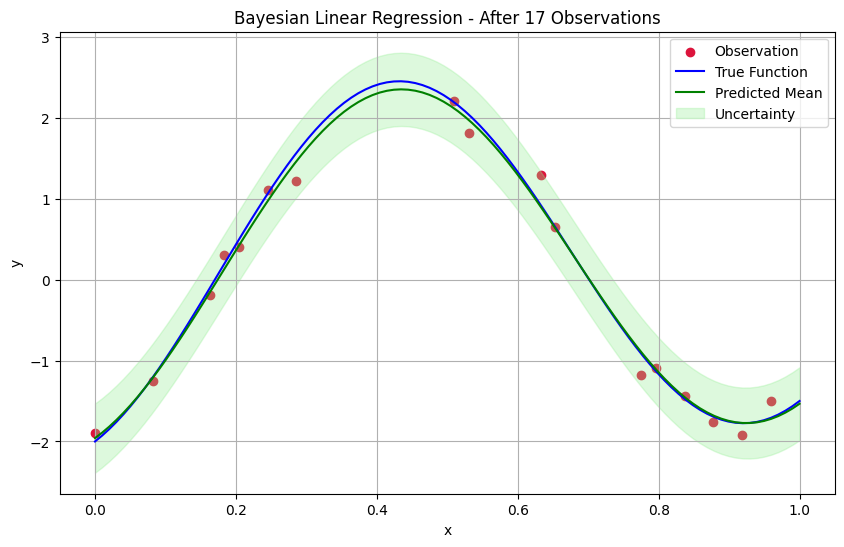

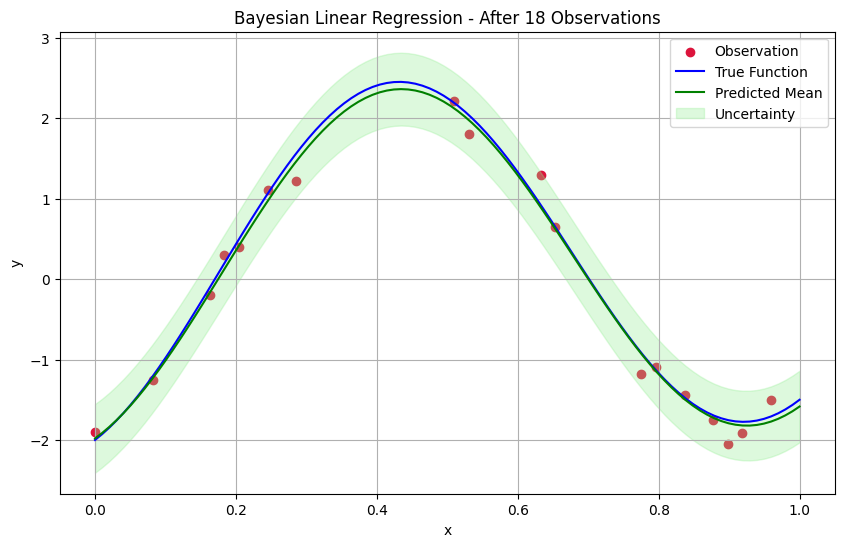

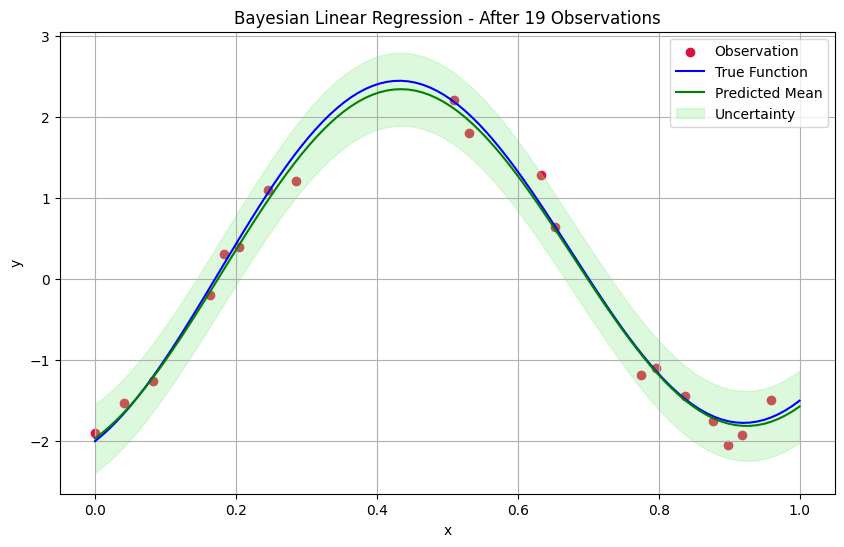

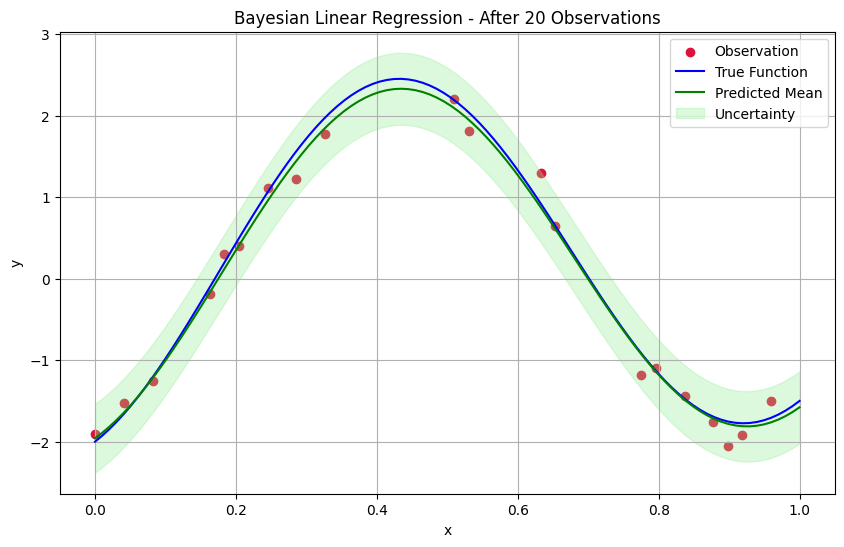

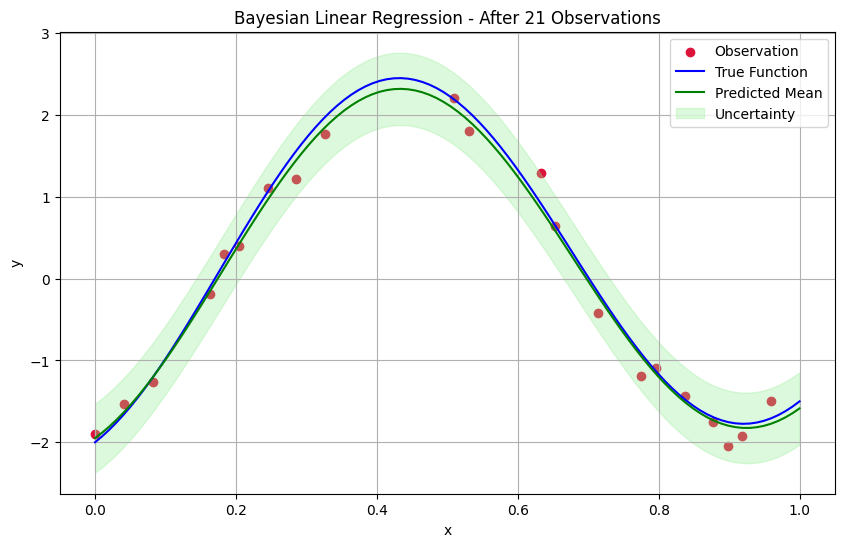

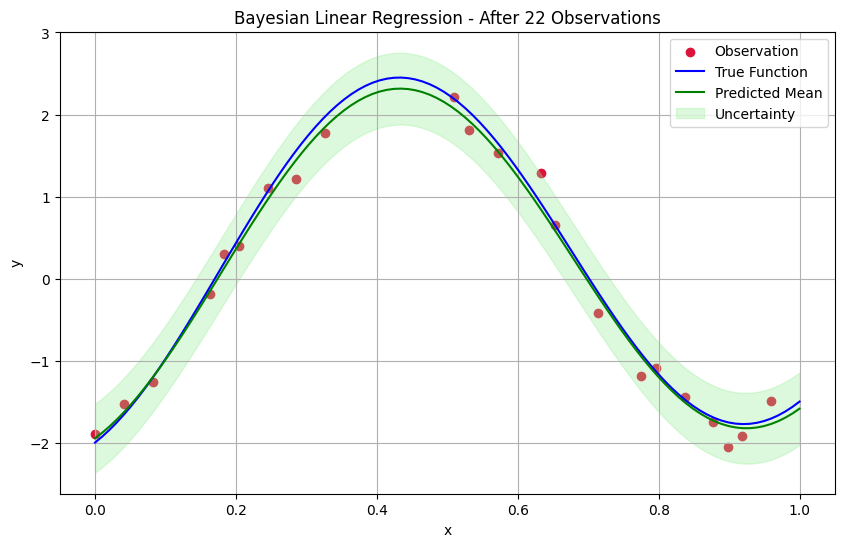

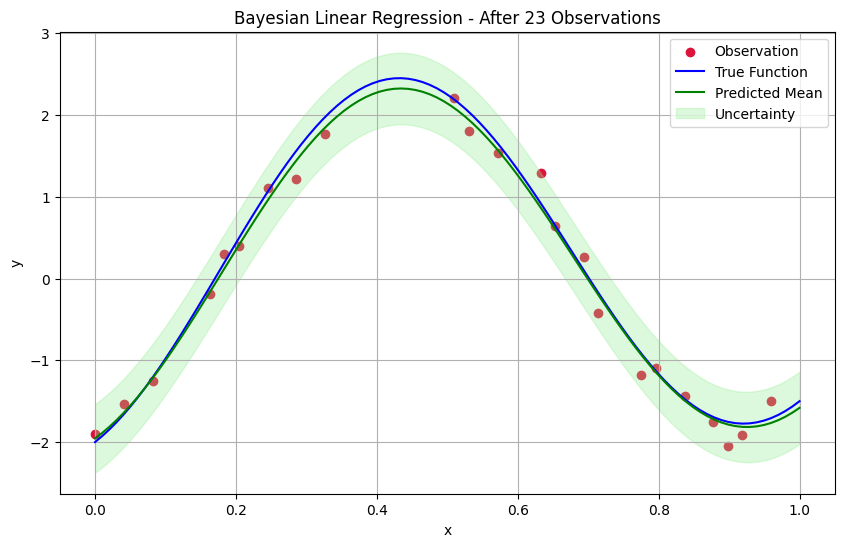

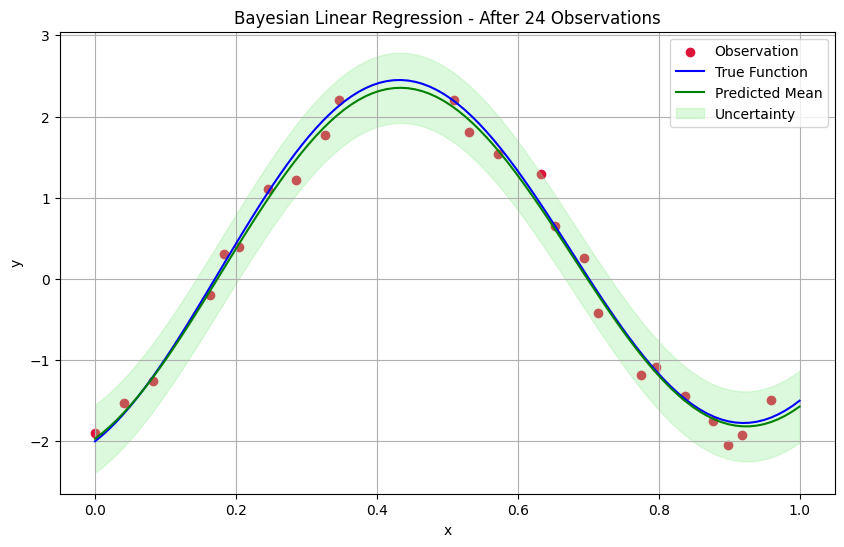

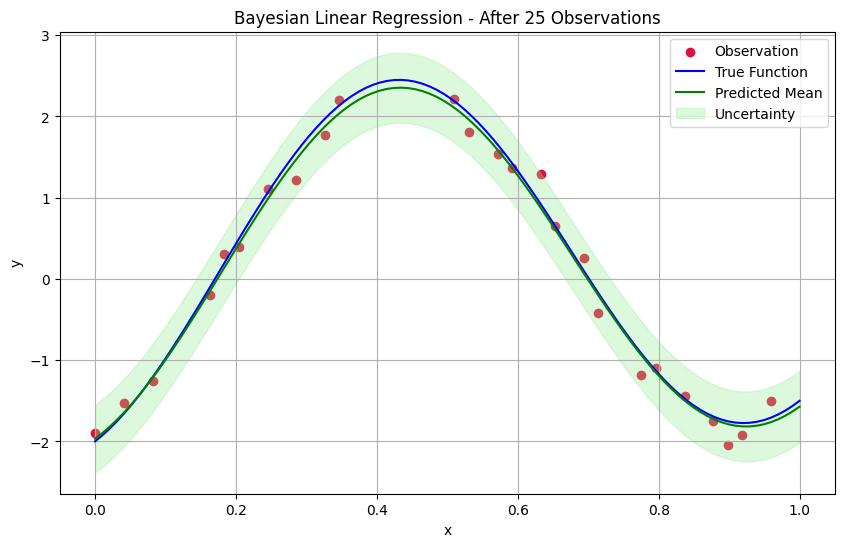

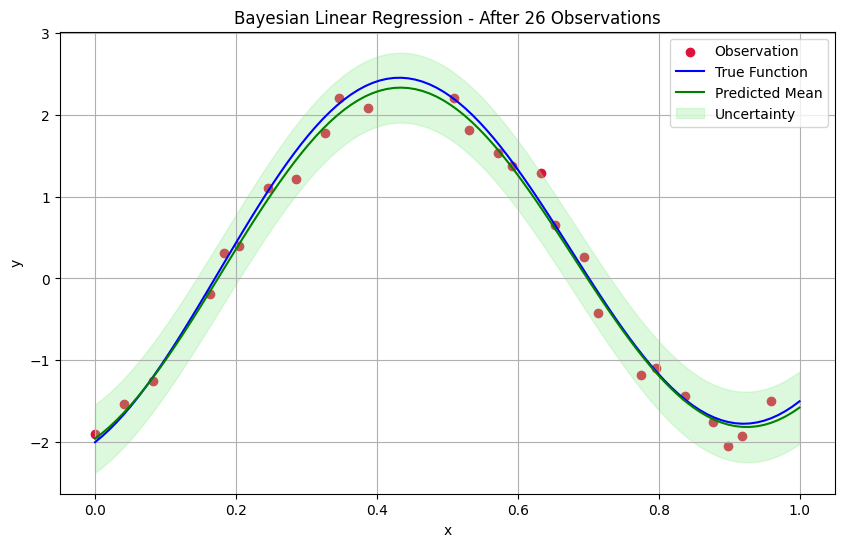

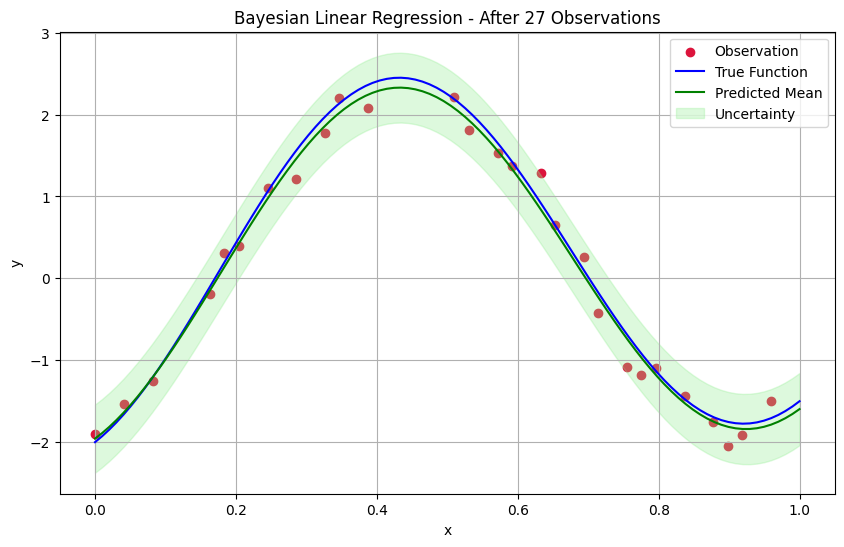

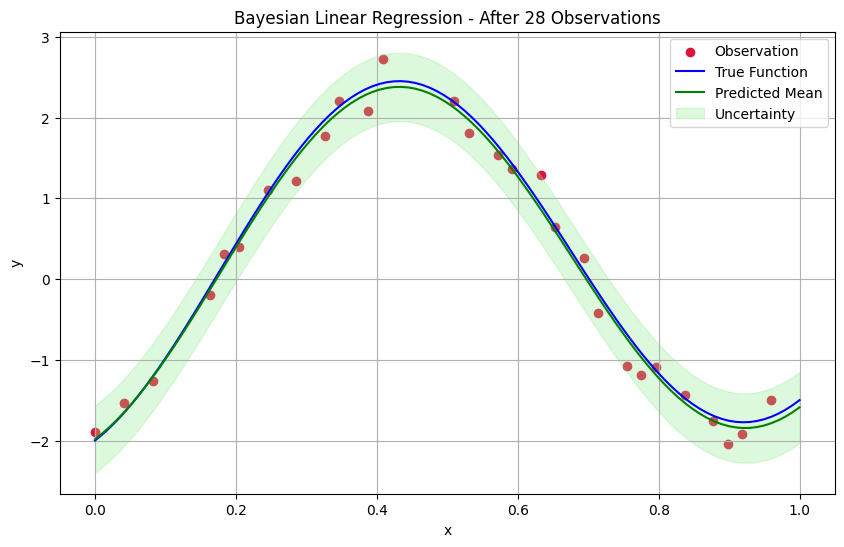

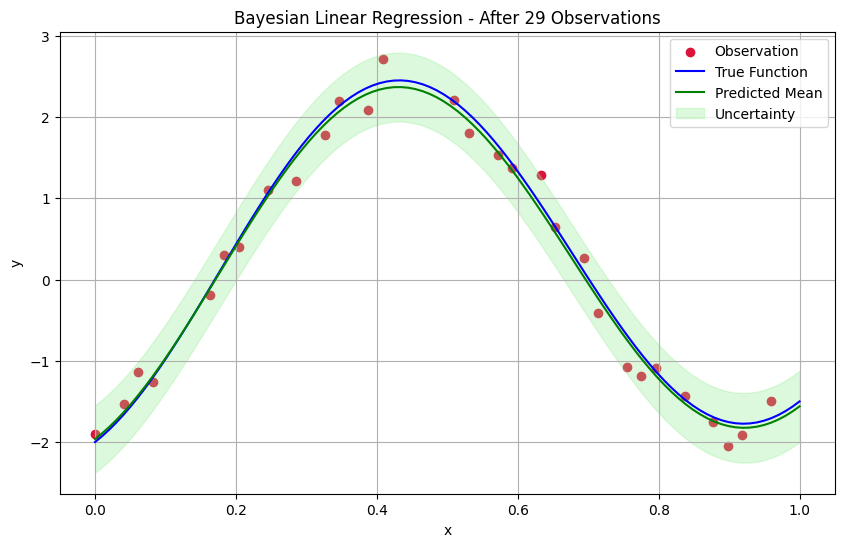

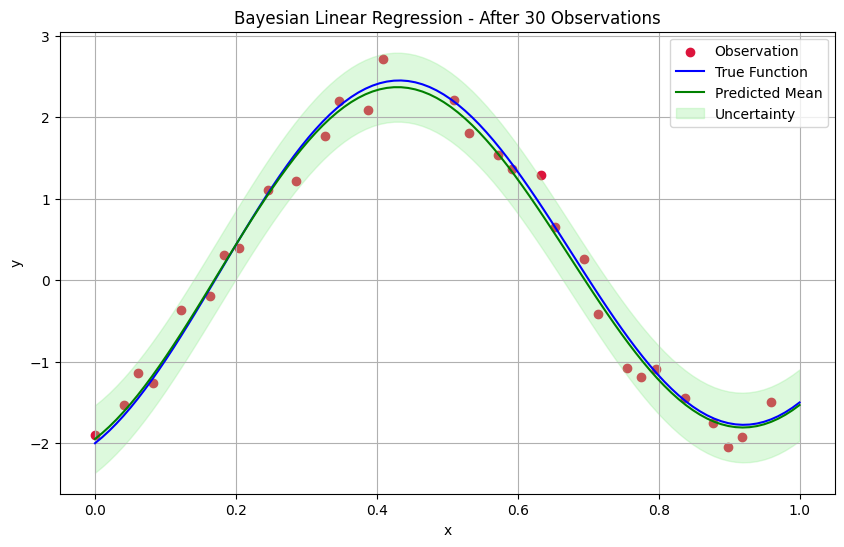

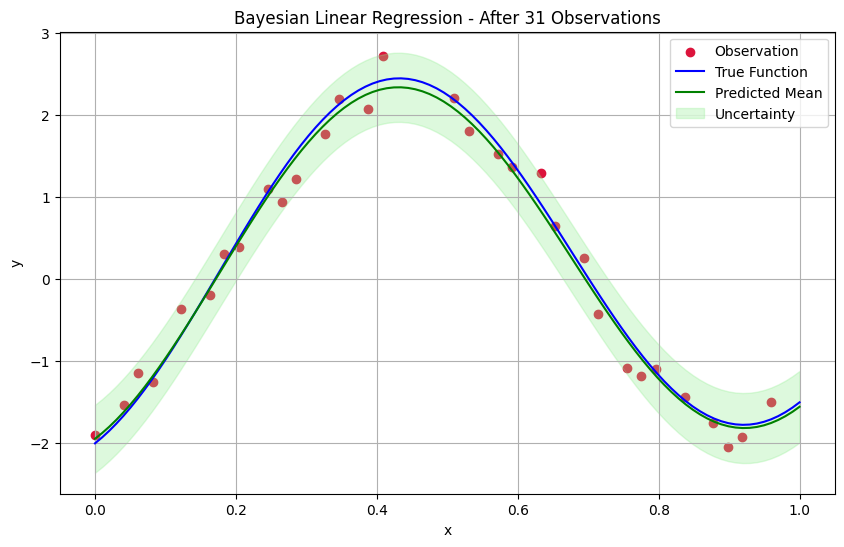

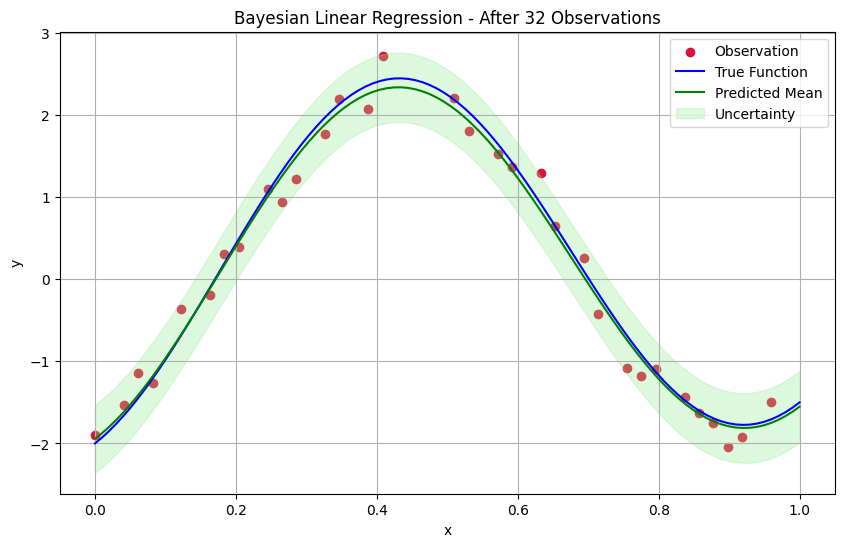

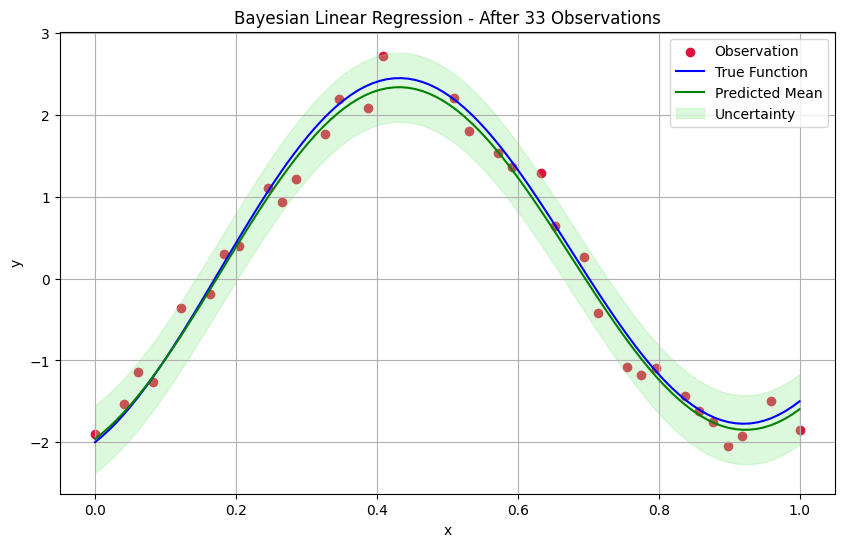

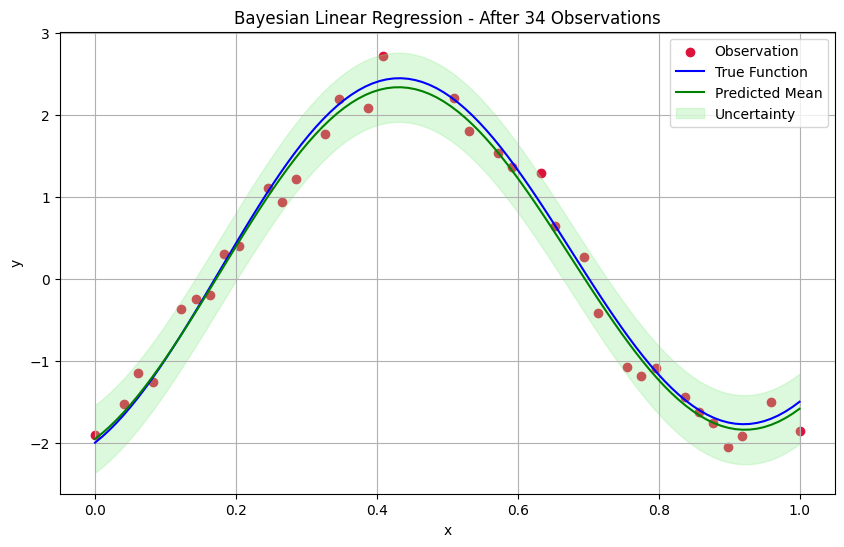

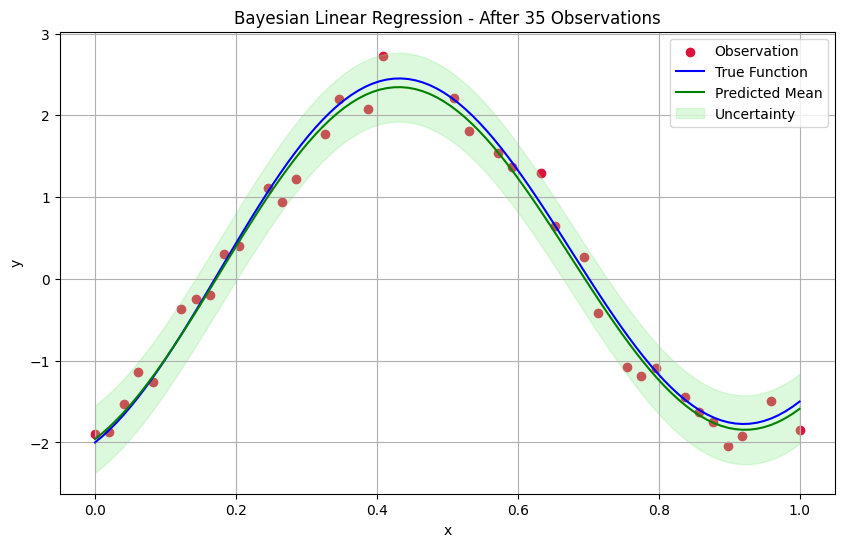

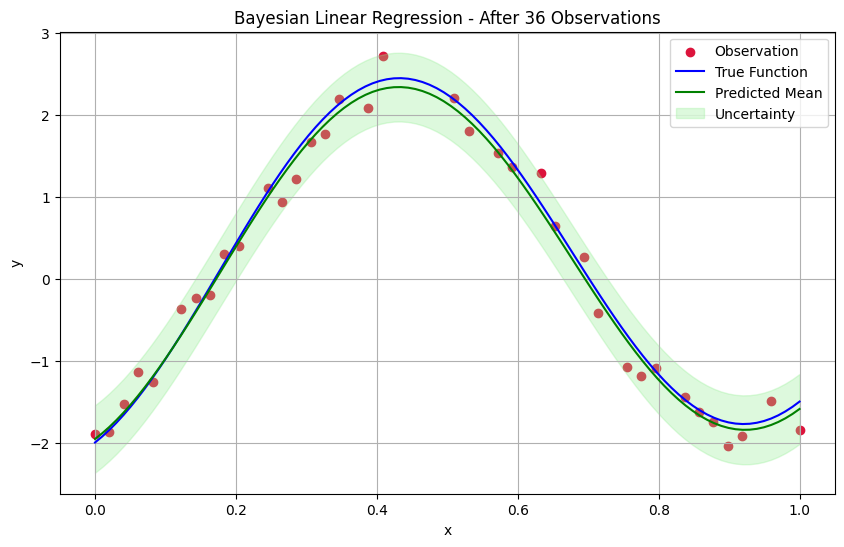

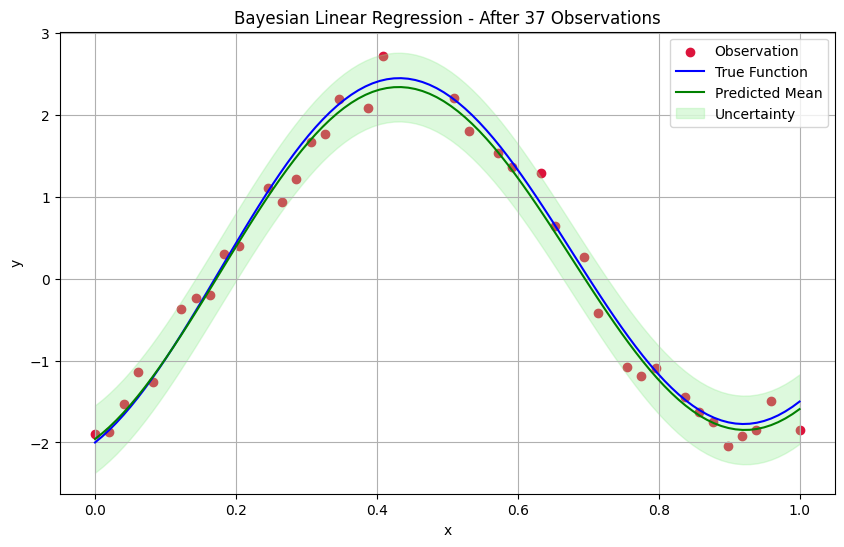

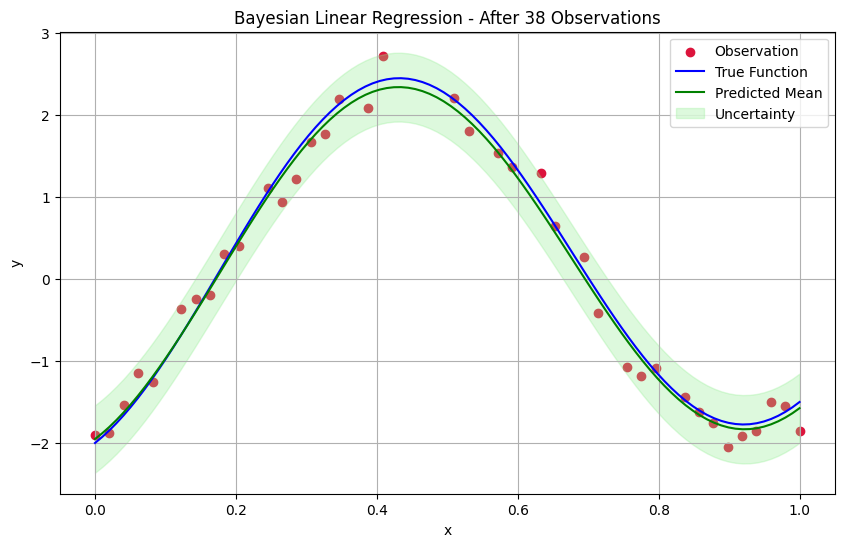

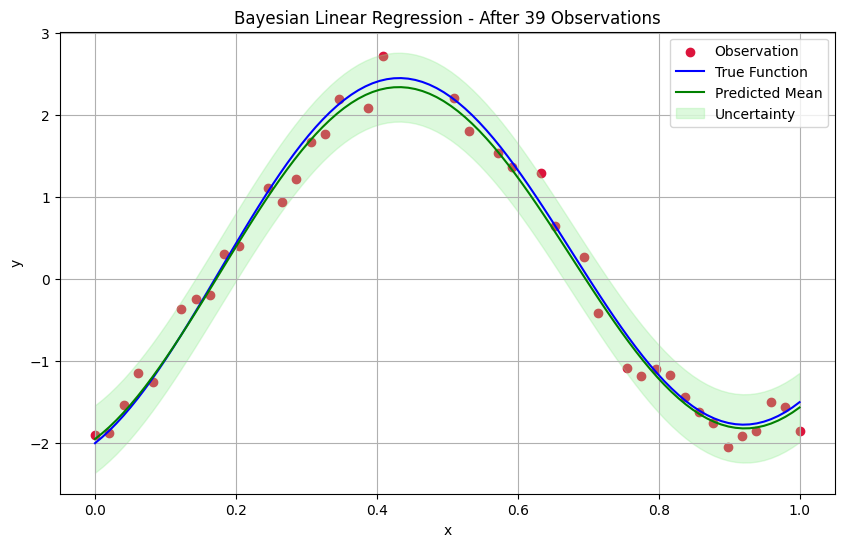

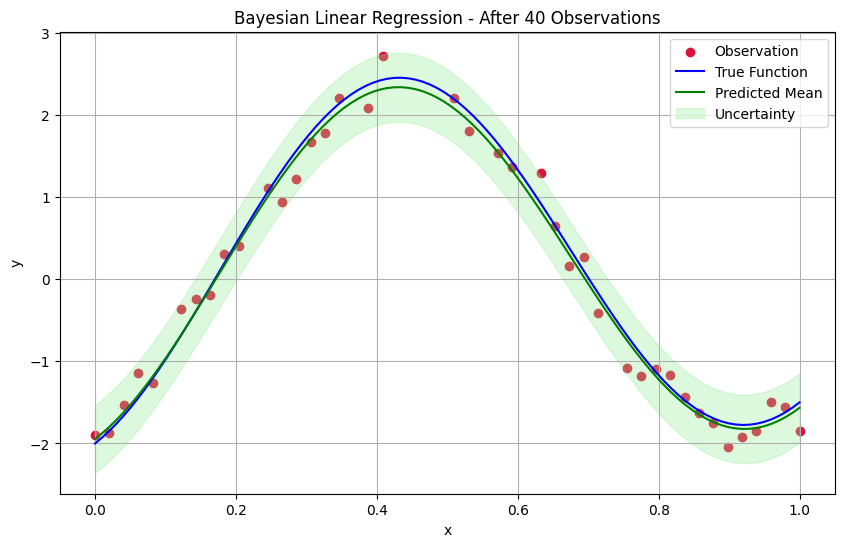

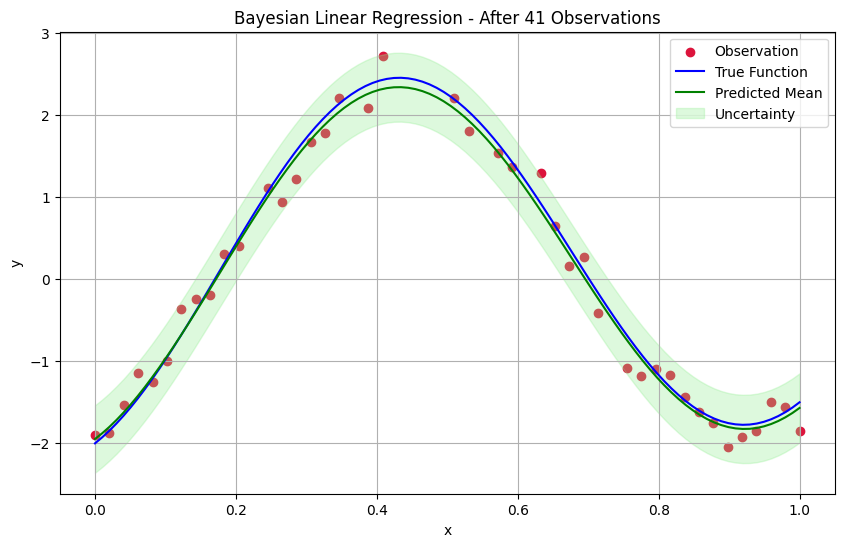

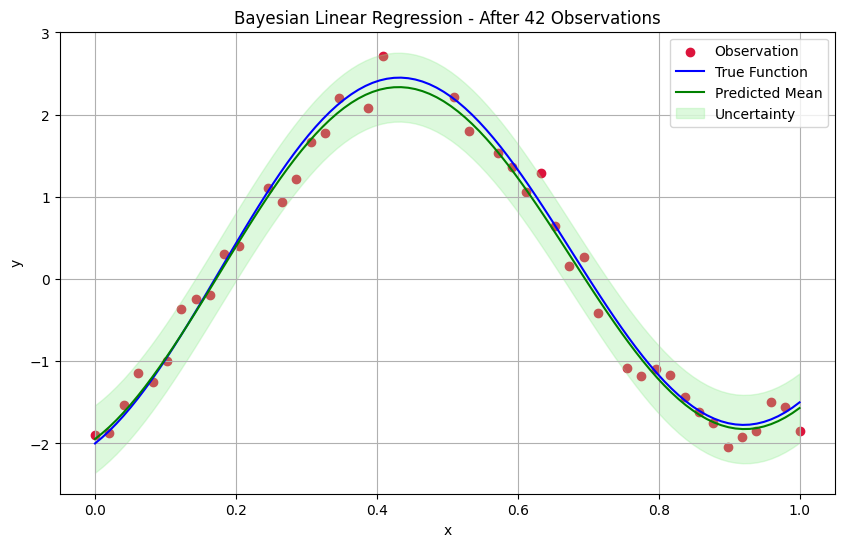

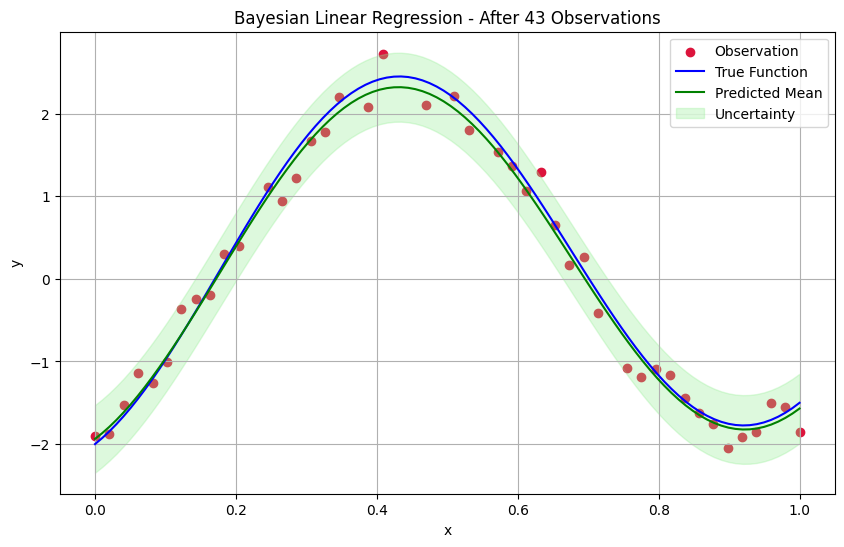

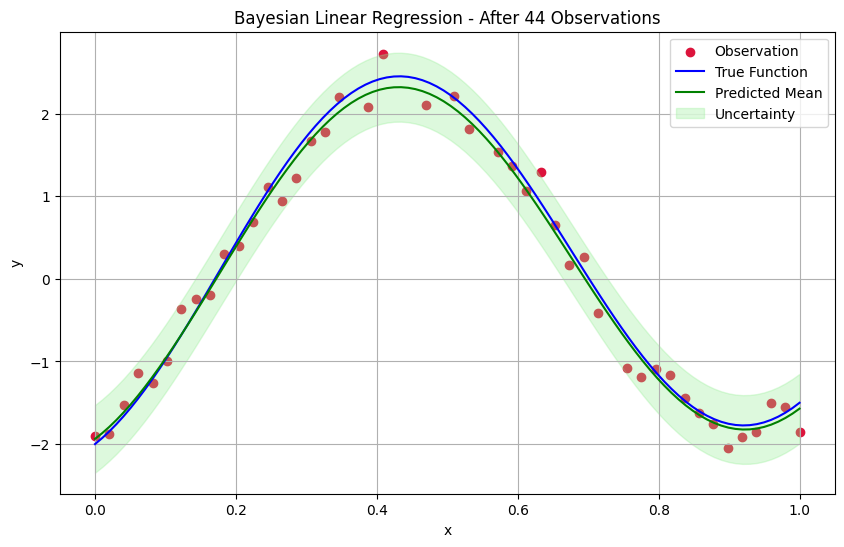

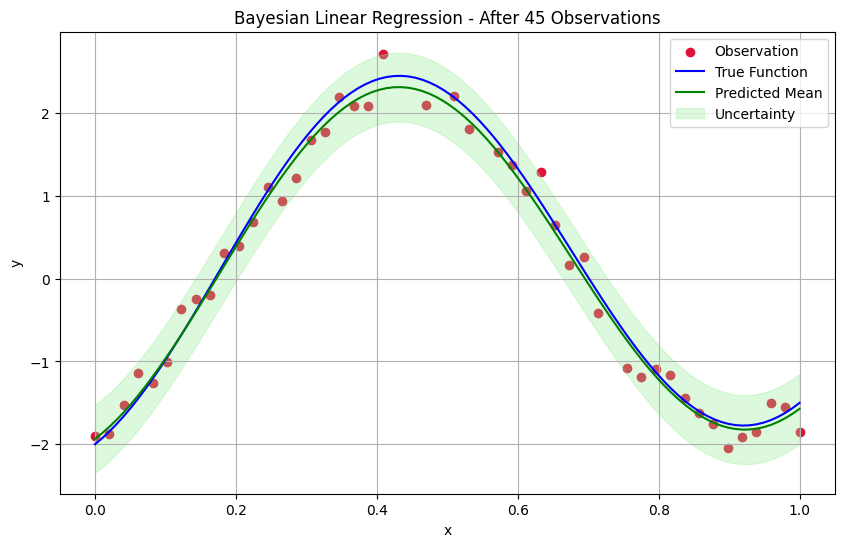

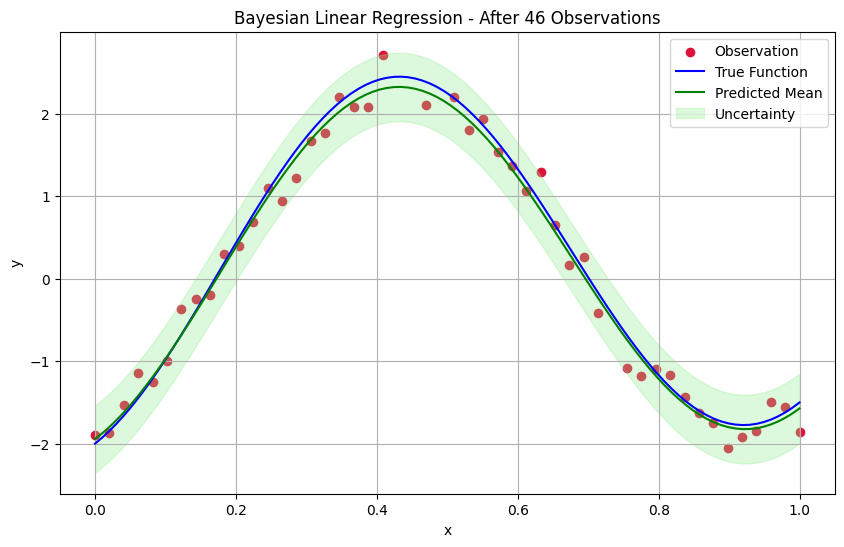

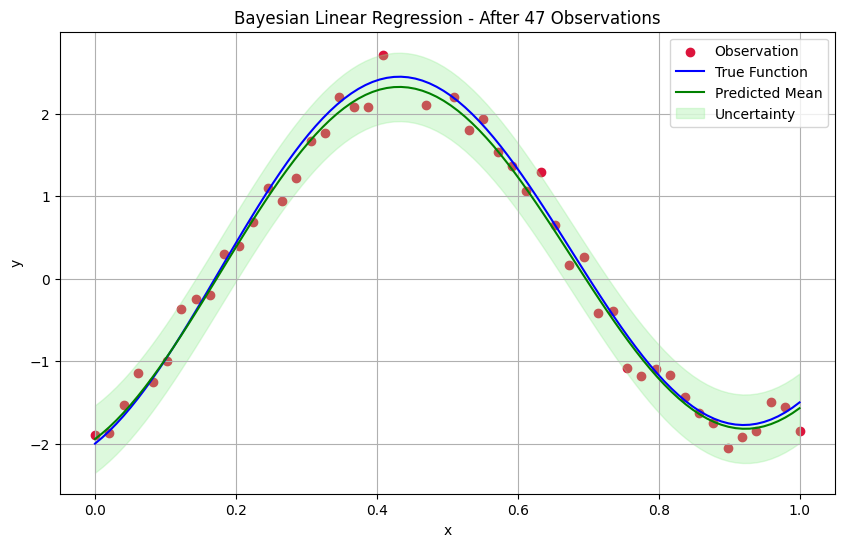

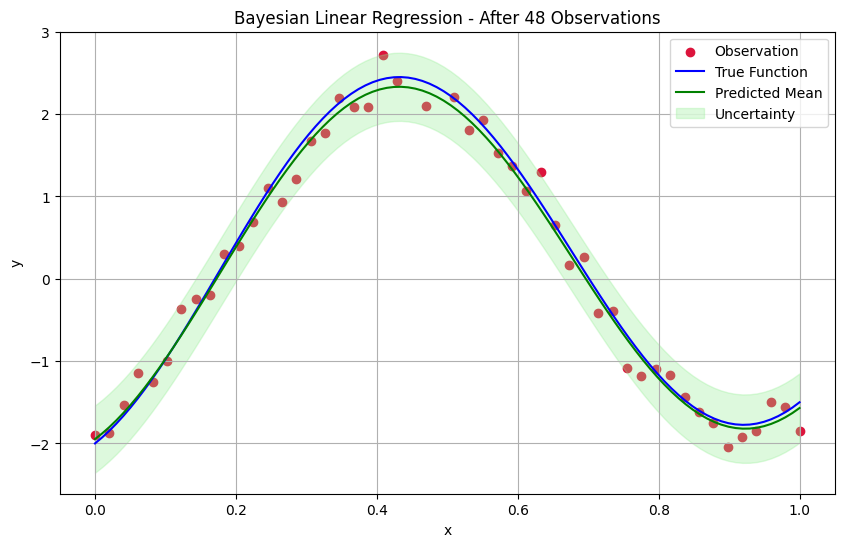

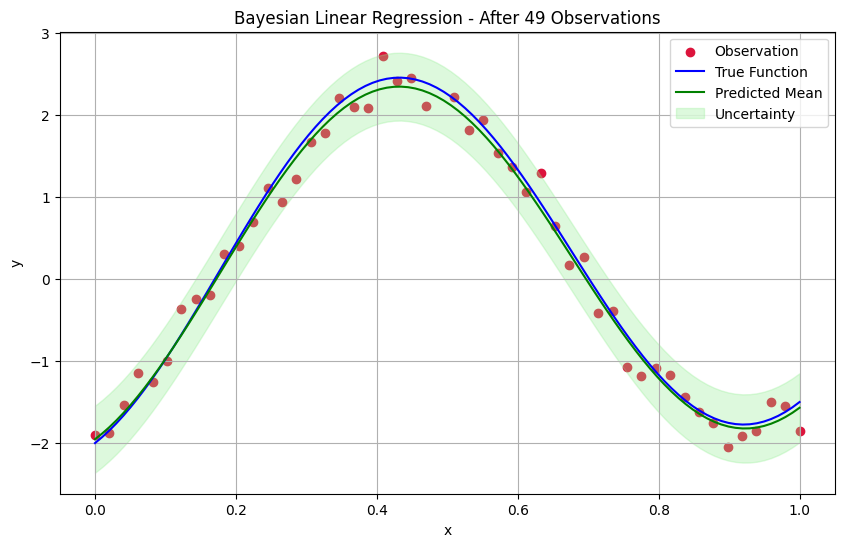

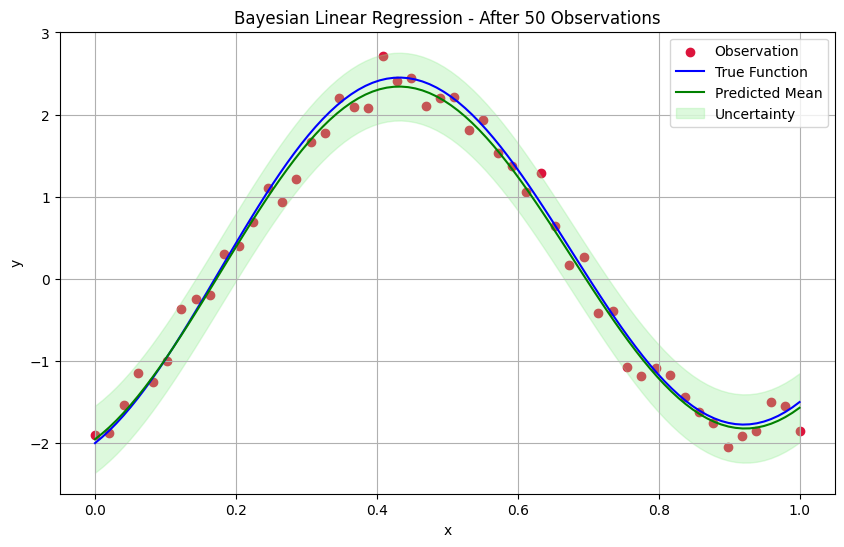

In [11]:
# データをｘの中からランダムに追加しながらモデルを逐次的に更新

import random
# 0からlen(x)-1までの数値をリストに格納
numbers = list(range(len(x)))
# リストの要素をランダムに並び替える
random.shuffle(numbers)

# ベイズ線形回帰モデルの初期化
model = BayesianLinearRegression(mu_prior, cov_prior, alpha, beta)

x_list = []
y_list = []

first_iteration = True

for repeat, number in enumerate(numbers):
    if not first_iteration:
        model.update_prior()
        
    first_iteration = False

    phi_new = phi[number:number+1, :]  # 新しいデータ点の特徴量
    y_new = y[number:number+1]         # 新しいデータ点のターゲット値
    
    x_list.append(x[number])
    y_list.append(y[number])

    # モデルの更新
    model.update(phi_new, y_new)

    # 予測のための入力データと予測分布の計算
    x_pred = np.linspace(0, 1, 100)
    phi_pred = calc_phi_tf(x_pred)  # 予測に使用する特徴量行列
    pred_mean, pred_cov = model.predict(phi_pred)
    pred_std = np.sqrt(pred_cov)

    # プロット
    plot_figure(x_list, y_list, x_pred, phi_pred, true_params, pred_mean, pred_std, title=f'Bayesian Linear Regression - After {repeat+1} Observations')

# Branch3: モデルエビデンスを用いた多項式におけるパラメタ数の決定(3.5.1)

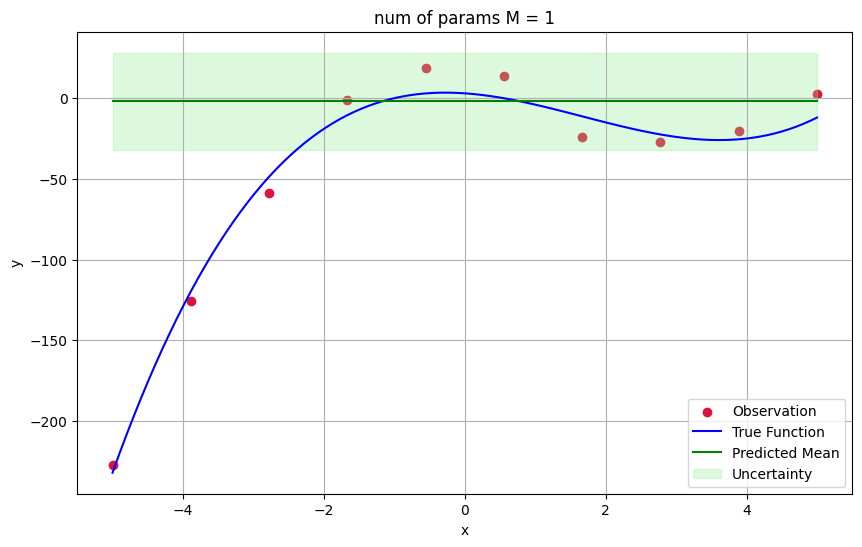

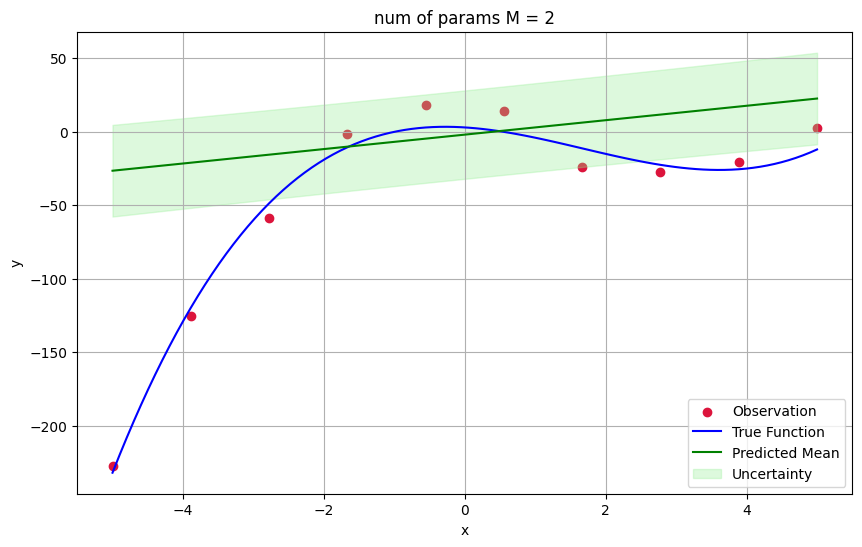

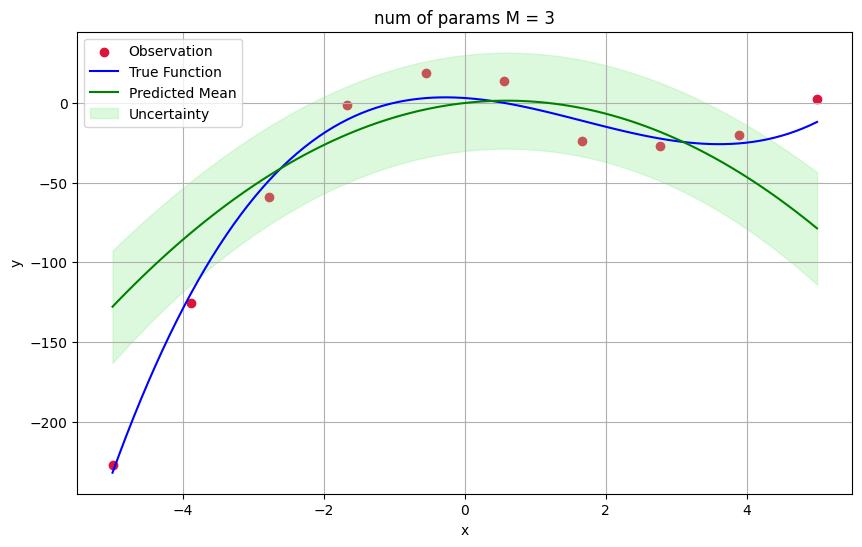

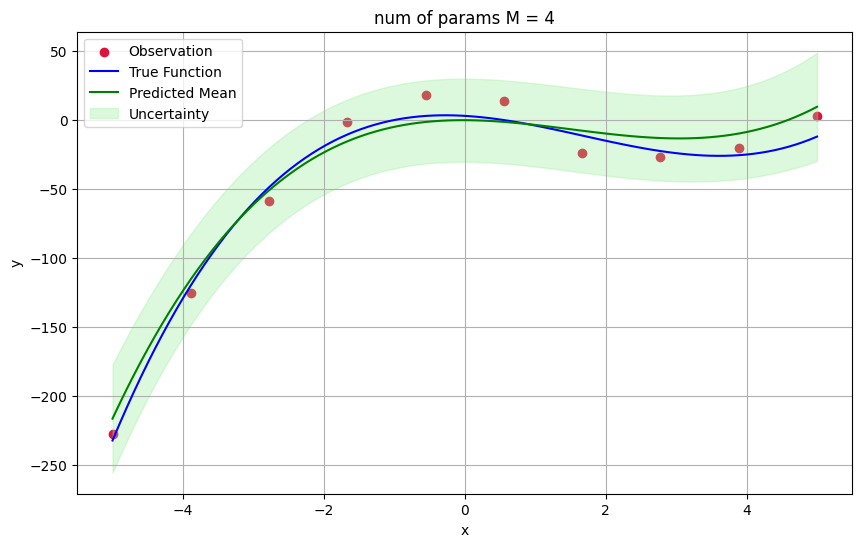

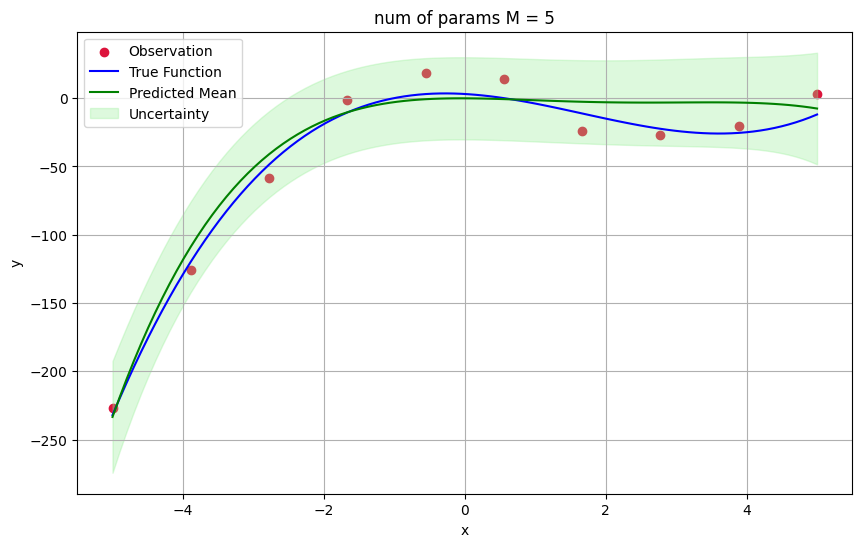

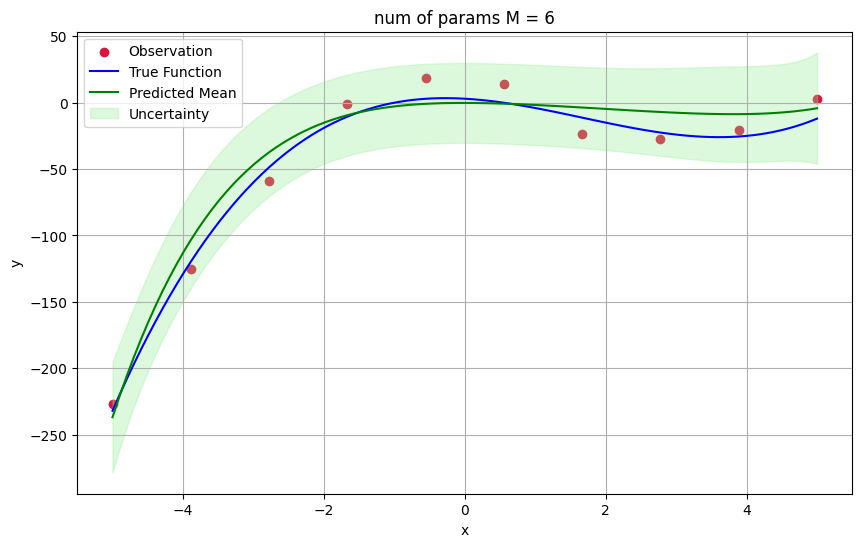

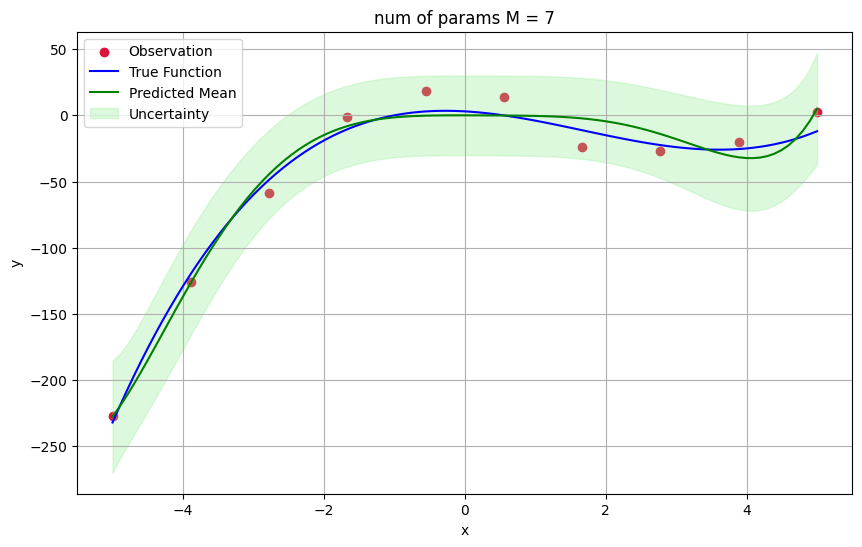

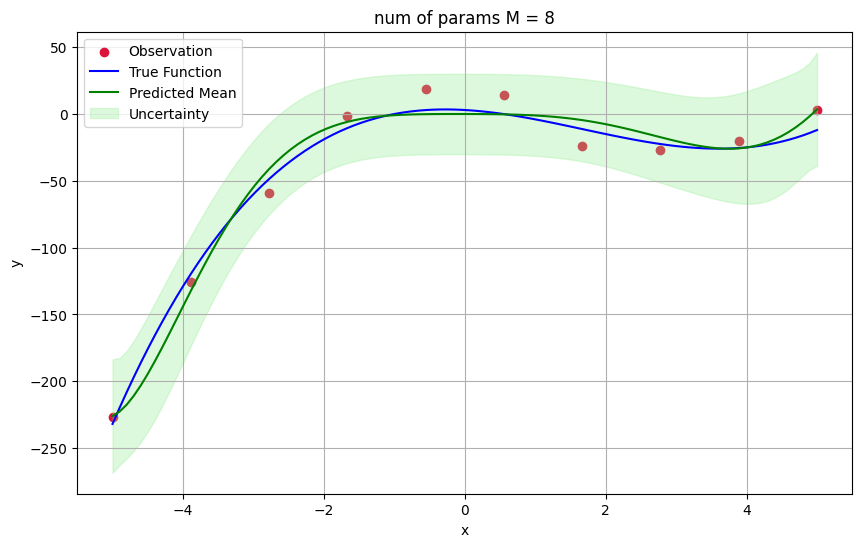

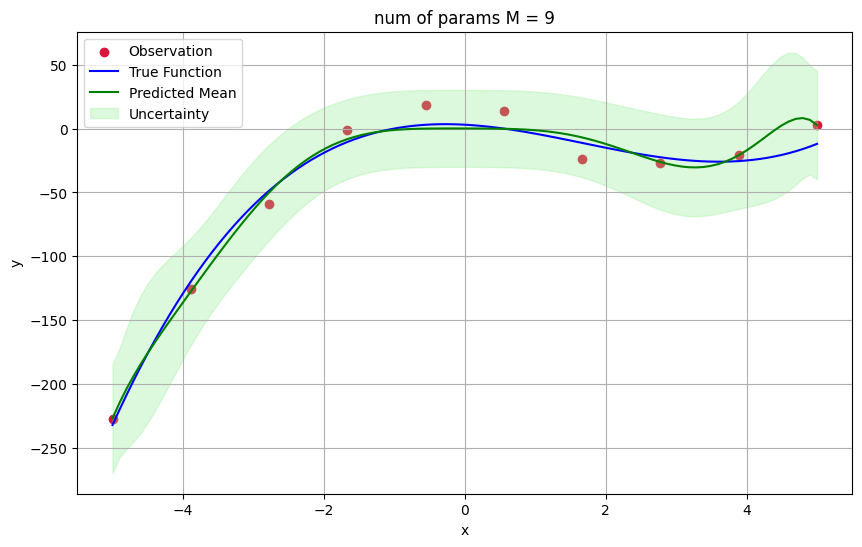

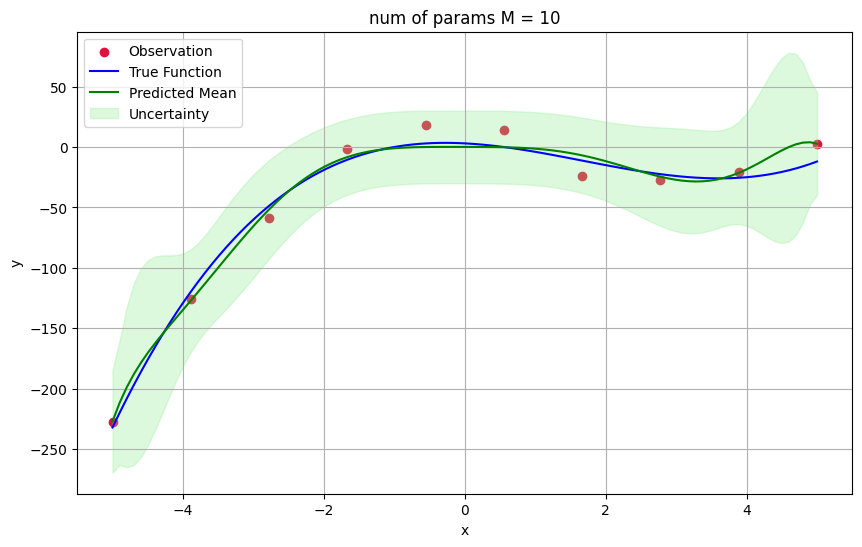

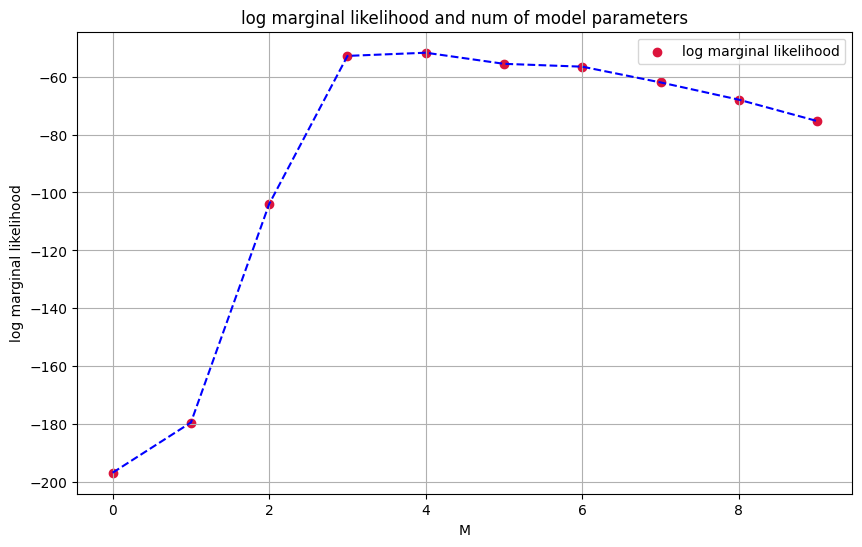

In [12]:
# サンプルデータ(3次多項式)の生成
x = np.linspace(-5, 5, 10)

# 3次多項式に対応する特徴量phiの生成関数
def calc_phi_poly(x):
    phi = np.column_stack([x**0, x, x**2, x**3])  # xの0次から3次までの4つの特徴量を使用
    return phi

phi_origin = calc_phi_poly(x)
true_params = np.array([3.0, -3.0, -5.0, 1.0]) #推定したいパラメータの真値
y_true = phi_origin @ true_params # xの三次関数
sigma = 15 # ノイズの標準偏差(既知とした)
noise = np.random.randn(len(x)) * sigma  # ノイズの生成(平均0, 標準偏差sigmaの正規分布)
y = y_true + noise

# 周辺尤度の対数を格納しておくリスト
ln_ml_list = []

# 試みるパラメタ数mの最大値
max_m = 10

for m in range(max_m):
    # m次多項式での近似における特徴量
    phi = np.column_stack([x**i for i in range(m+1)])
    # パラメータの事前分布の設定

    alpha = 1
    mu_prior = np.zeros(phi.shape[1])     # パラメータの事前平均をゼロベクトルで初期化
    cov_prior = alpha * np.identity(phi.shape[1]) # パラメータの事前共分散行列を単位行列で初期化
    beta = 1.0 / (sigma ** 2)             # ノイズの精度パラメータを計算(sigmaを既知としている)

    # ベイズ線形回帰モデルの初期化
    model = BayesianLinearRegression(mu_prior, cov_prior, alpha, beta)
    # モデルの学習
    model.update(phi, y)

    # 新しい入力データに対する予測分布の計算
    x_pred = np.linspace(-5, 5, 100)
    phi_pred = np.column_stack([x_pred**i for i in range(m+1)])  # 予測に使用する特徴量行列
    pred_mean, pred_cov = model.predict(phi_pred)
    pred_std = np.sqrt(pred_cov)
    
    N, D = phi.shape
    # p166 式(3.82)
    e_mn = (beta / 2) * np.sum((y - phi @ model.mu_posterior) ** 2) + (alpha / 2) * np.sum(model.mu_posterior ** 2) 
    # 式(3.54)
    a = np.linalg.inv(model.cov_posterior)
    
    # p166 式(3.86)　周辺尤度関数の対数
    ln_ml  =  (m / 2) * np.log(alpha) \
                    + (N / 2) * np.log(beta) \
                    - e_mn \
                    - (1 / 2) * np.log(np.linalg.det(a)) \
                    - (N / 2) * np.log(2 * np.pi)  
    
    ln_ml_list.append(ln_ml)
    
    # 可視化
    phi_origin= calc_phi_poly(x_pred)
    plot_figure(x, y, x_pred, phi_origin, true_params, pred_mean, pred_std, title=f'num of params M = {m+1}')

    
# 周辺尤度の対数とモデルのパラメター数の可視化
plt.figure(figsize=(10, 6))
m_list = np.arange(0, max_m, 1)
plt.scatter(m_list, ln_ml_list, c='crimson', marker='o', label='log marginal likelihood')
plt.plot(m_list, ln_ml_list, color='blue', linestyle='--')
plt.title('log marginal likelihood and num of model parameters')
plt.xlabel('M')
plt.ylabel('log marginal likelihood')
plt.legend()
plt.grid(True)
plt.show()

# Challenge: 実データへの適用

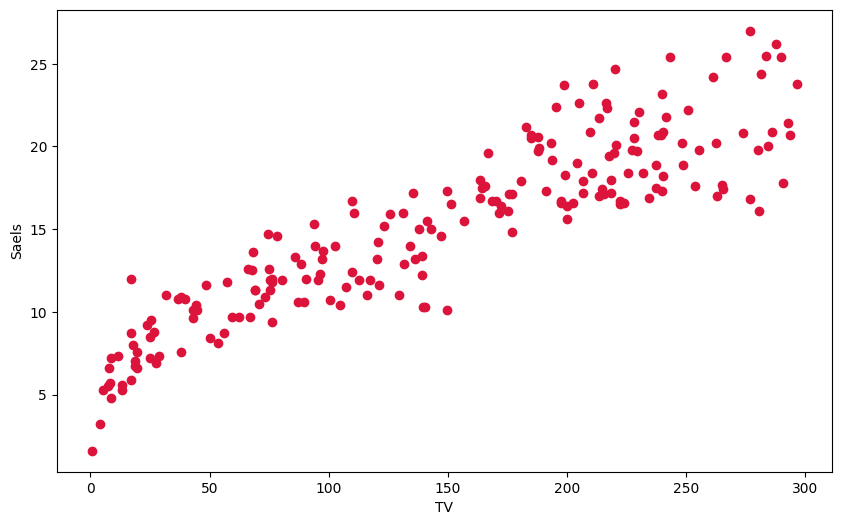

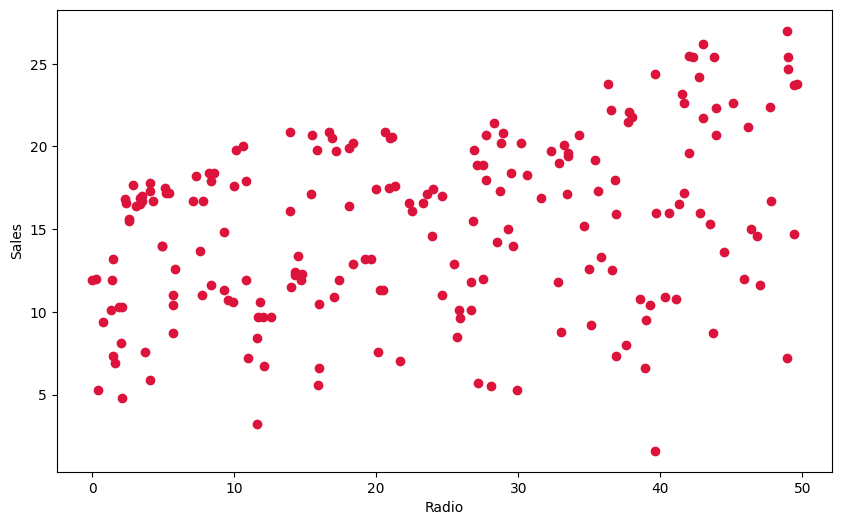

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

def x_to_phi(x, typ='linear', degree=3):
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    return np.concatenate([np.ones(x.shape[0]).reshape(-1, 1), x], axis=1)


df = pd.read_csv("advertising.csv")
x = df[['TV', 'Radio']].values
y = df['Sales'].values

phi = x_to_phi(x)
x_train, x_test, phi_train, phi_test, y_train, y_test = \
    train_test_split(x, phi, y, train_size=0.05, random_state=0)

# データの可視化 
plt.figure(figsize=(10, 6))
plt.scatter(df['TV'], df['Sales'], c='crimson', marker='o', label='Observation')
plt.xlabel('TV')
plt.ylabel('Saels')
plt.show()

# データの可視化 
plt.figure(figsize=(10, 6))
plt.scatter(df['Radio'], df['Sales'], c='crimson', marker='o', label='Observation')
plt.xlabel('Radio')
plt.ylabel('Sales')
plt.show()